In [17]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
#import torch

In [3]:
metagenomes = ['ERR598962','ERR599055','ERR598957','ERR599072']
metagenome_id = 'ERR598962'
'''
station 102 dcm and meso (upwelling) -- dcm: ERR598962 (23M reads); meso: ERR599055 (23M)
station 112 DCM and meso (SPG) -- dcm: ERR598957 (200M); meso: ERR599072 (150M)
'''

'\nstation 102 dcm and meso (upwelling) -- dcm: ERR598962 (23M reads); meso: ERR599055 (23M)\nstation 112 DCM and meso (SPG) -- dcm: ERR598957 (200M); meso: ERR599072 (150M)\n'

In [18]:
def get_scores(labels, preds):

    TP = np.sum(np.logical_and(predicted == True, true == True))
    TN = np.sum(np.logical_and(predicted == False, true == False))
    FP = np.sum(np.logical_and(predicted == True, true == False))
    FN = np.sum(np.logical_and(predicted == False, true == True))

    acc = (TP+TN)/(TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = 2*((precision*recall)/(precision+recall))

    return acc,precision,recall,f1


# validset analysis

In [ ]:
preds = pd.read_csv('validset_predictions.csv')
print(preds.head())
valid = pd.read_csv('ec1_valid.csv')
valid.head()

In [20]:
print(len(preds))
print(len(valid))

279200
279200


In [21]:
print(preds['seq'][1000])
print(valid['seq'][1000])

TATCAAGAAGTTTACGCTTACGAGAAATGTCACCACCGTAACATTTCGCAAGTACGTTTTTACGCATCGCTTTAATTGTAGAACGCGCTACAACTTTGTTTC
TATCAAGAAGTTTACGCTTACGAGAAATGTCACCACCGTAACATTTCGCAAGTACGTTTTTACGCATCGCTTTAATTGTAGAACGCGCTACAACTTTGTTTC


In [22]:
print(preds['preds'][0].split('tensor('))
print(float(preds['preds'][0].split('tensor(')[1].split(')')[0]))
print(float(preds['preds'][0].split('tensor(')[2].split(')')[0]))

['(', '1.), ', '5.8464e-08))']
1.0
5.8464e-08


In [23]:
preds['true_label'] = valid['label']
preds['EMBL_CDS_id'] = valid['EMBL_CDS_id']
preds['pred_ec1'] = [float(x.split('tensor(')[1].split(')')[0]) for x in preds['preds']]
preds['pred_nonec1'] = [float(x.split('tensor(')[2].split(')')[0]) for x in preds['preds']]
preds.head()

,preds,predicted_label,seq,pred_nonec1,pred_ec1,true_label,EMBL_CDS_id
0,"(tensor(1.), tensor(5.8464e-08))",ec1,TCCCATTTAGCTGGGCATACTTCGCCAGGGTTTTTACGAACATATT...,5.846400e-08,1.0000,ec1,BAB41593.1
1,"(tensor(0.1988), tensor(0.8012))",nonec1,GAAAATACTTTTAAATATATGTTTAACAAGGGAATCGGAACAAAGC...,8.012000e-01,0.1988,nonec1,DAA08282.1
2,"(tensor(0.2955), tensor(0.7045))",nonec1,TCTGTTTCCTGTCTTCTTTGGATAAACTCATCAGCAACCCTGGTAC...,7.045000e-01,0.2955,nonec1,ABG48470.1
3,"(tensor(0.0369), tensor(0.9631))",nonec1,TCCTCCAGATGCAGGCGGTCCAGCATTTCATAAACTATGGTTTCCC...,9.631000e-01,0.0369,nonec1,EDM14285.1
4,"(tensor(0.8211), tensor(0.1789))",ec1,AGGAATTTTGGCTGCTATCAACACCGTAAGAACCGGAATAGCTGAT...,1.789000e-01,0.8211,nonec1,CAA88763.1


In [24]:
np.sum(preds['predicted_label']==preds['true_label'])/len(preds)

0.8226289398280803

In [25]:
cutoff=0.99
predicted = preds['pred_ec1']>=cutoff
true = preds['true_label']=='ec1'
acc,precision,recall,f1 = get_scores(labels=true, preds=predicted)
print(acc,precision,recall,f1)

0.7250931232091691 0.9885112866115291 0.45547994269340975 0.6236146799788156


In [26]:
metrics = pd.DataFrame()
for cutoff in np.arange(0,1.0,0.01): #[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1.0]:
    predicted = preds['pred_ec1']>=cutoff
    true = preds['true_label']=='ec1'
    acc,precision,recall,f1 = get_scores(labels=true, preds=predicted)
    metrics = metrics.append([[cutoff,acc,precision,recall,f1]])
metrics.columns = ['cutoff','accuracy','precision','recall','f1']

In [27]:
metrics.head()

,cutoff,accuracy,precision,recall,f1
0,0.00,0.500000,0.500000,1.000000,0.666667
0,0.01,0.674878,0.607862,0.985537,0.751940
0,0.02,0.707110,0.635070,0.973782,0.768772
0,0.03,0.726812,0.653807,0.964140,0.779212
0,0.04,0.740630,0.668206,0.955917,0.786577


In [28]:
metrics[metrics['accuracy']==metrics['accuracy'].max()]

,cutoff,accuracy,precision,recall,f1
0,0.47,0.823109,0.846442,0.789434,0.816945


In [29]:
metrics[metrics['cutoff']==0.5]

,cutoff,accuracy,precision,recall,f1
0,0.5,0.82265,0.852961,0.779713,0.814694


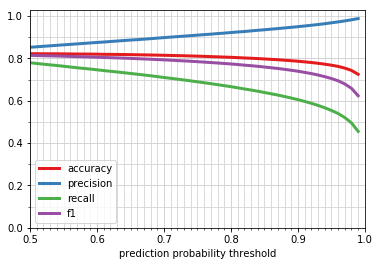

In [30]:
colors = sns.color_palette('Set1',4)
fig,ax = plt.subplots()
plt.plot( 'cutoff', 'accuracy', data=metrics, color=colors[0], linewidth=3)
plt.plot( 'cutoff', 'precision', data=metrics, color=colors[1], linewidth=3)
plt.plot( 'cutoff', 'recall', data=metrics, color=colors[2], linewidth=3)
plt.plot( 'cutoff', 'f1', data=metrics, color=colors[3], linewidth=3)
plt.legend()
ax.set_xticks(ticks=np.arange(0.5,1.0,0.01),minor=True)
ax.set_yticks(ticks=np.arange(0,1.0,0.1),minor=True)
plt.xlim((0.5,1.0))
ax.set_xlabel('prediction probability threshold')
plt.grid(b=True,which='minor',color='lightgray')
plt.grid(b=True,which='major',color='lightgray')
plt.savefig('validset_metrics.png',dpi=150)

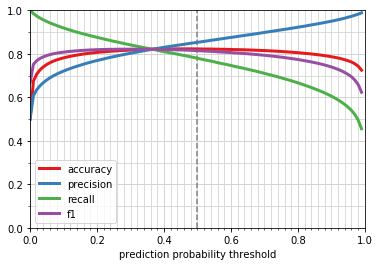

In [31]:
colors = sns.color_palette('Set1',4)
fig,ax = plt.subplots()
plt.plot( 'cutoff', 'accuracy', data=metrics, color=colors[0], linewidth=3)
plt.plot( 'cutoff', 'precision', data=metrics, color=colors[1], linewidth=3)
plt.plot( 'cutoff', 'recall', data=metrics, color=colors[2], linewidth=3)
plt.plot( 'cutoff', 'f1', data=metrics, color=colors[3], linewidth=3)
plt.legend()
ax.set_xticks(ticks=np.arange(0,1.0,0.02),minor=True)
ax.set_yticks(ticks=np.arange(0,1.0,0.1),minor=True)
plt.xlim((0,1.0))
plt.ylim((0,1))
plt.vlines(x=0.5, ymin=0,ymax=1,linestyles='dashed',linewidth=1.5,color='gray')
ax.set_xlabel('prediction probability threshold')
plt.grid(b=True,which='minor',color='lightgray')
plt.grid(b=True,which='major',color='lightgray')
plt.savefig('validset_metrics_all.png',dpi=150)

In [32]:
print(np.mean(preds['pred_ec1']))
print(np.median(preds['pred_ec1']))
print(np.min(preds['pred_ec1']))
print(np.max(preds['pred_ec1']))

0.4688367829403248
0.366
2.5127e-13
1.0


# metagenomes

In [79]:
#for metagenome_id in metagenomes:
print('analyzing metagenome',metagenome_id,'...')
preds = pd.read_csv(str(metagenome_id)+'_cut_2M_predictions.csv')

preds.head()

analyzing metagenome ERR598962 ...


,Unnamed: 0,preds,predicted_label,seq,desc,mifaser_ec_1,mifaser_ec_2,pred_nonec1,pred_ec1
0,0,"(tensor(0.1461), tensor(0.8539))",nonec1,CTAAAAACCCTTGTTTTTATGAATTCATTAGACGCTAACATCAGAA...,ERR598962.sra.1/1PHOSPHORE:0133:0:2:1101:1270:...,NaN,NaN,0.853877,0.146123
1,1,"(tensor(0.0323), tensor(0.9677))",nonec1,TTTTCAATTAGTGATTTAAGTATTTTTTTAGATATAGAAATTTTTT...,ERR598962.sra.1/2PHOSPHORE:0133:0:2:1101:1270:...,NaN,NaN,0.967677,0.032323
2,2,"(tensor(0.0610), tensor(0.9390))",nonec1,CTCTTGCCTGTTACAAAAGTAATCGAGACATGCTCGTTAGCAGAAA...,ERR598962.sra.2/1PHOSPHORE:0133:0:2:1101:1490:...,NaN,NaN,0.939011,0.060990
3,3,"(tensor(0.1799), tensor(0.8201))",nonec1,TCAGAATATATCCTGCTATTTAGCATTTCTTCTCCAACAATTTCTC...,ERR598962.sra.2/2PHOSPHORE:0133:0:2:1101:1490:...,NaN,NaN,0.820122,0.179878
4,4,"(tensor(0.1084), tensor(0.8916))",nonec1,TTGATTTATGTATAAACCTATAGCAATTGTTCCAACAATACTCACA...,ERR598962.sra.3/1PHOSPHORE:0133:0:2:1101:1536:...,NaN,NaN,0.891587,0.108413


In [7]:
for metagenome_id in metagenomes:
    print('analyzing metagenome',metagenome_id,'...')
    preds = pd.read_csv(str(metagenome_id)+'_cut_2M_predictions.csv')
    print('number of reads predicted as ec1:',len(preds[preds['predicted_label']=='ec1']),'or',len(preds[preds['predicted_label']=='ec1'])/len(preds),'percent')
    print('number of reads annotated by mifaser:',len(preds['mifaser_ec_1'].dropna()),'out of',len(preds))
    annotated = preds.dropna(subset=['mifaser_ec_1'])
    print('percent reads annotated:',len(annotated)/len(preds))
    true_ec1s = annotated[annotated['mifaser_ec_1'].str.startswith('1.')]
    print('number of reads annotated as ec1 by mifaser:',len(true_ec1s))
    true_nonec1s = annotated[~annotated['mifaser_ec_1'].str.startswith('1.')]
    annotated_predec1 = annotated[annotated['predicted_label']=='ec1']
    agree = annotated_predec1[annotated_predec1['mifaser_ec_1'].str.startswith('1.')]
    print('percent of annotated reads agree on ec1 between LG and mifaser:',len(agree)/len(annotated_predec1))
    annotated_prednonec1 = annotated[annotated['predicted_label']=='nonec1']


    print('average pred probability for agreed-upon ec1 predictions between LookingGlass and mifaser:',np.mean(agree['pred_ec1']))
    print('overall mean pred probability for LookingGlass ec1 predictions:',np.mean(preds[preds['predicted_label']=='ec1']['pred_ec1']) )

    for cutoff in [0.5,0.8,0.85,0.9,0.92,0.94,0.96,0.97,0.98,0.99]:
        above = preds[preds['pred_ec1']>cutoff] 
        print(len(above),'(',len(above)*100/len(preds),'%), ec1 preds with prob >',cutoff)
        above_annotated = above.dropna(subset=['mifaser_ec_1'])
        print('of',len(above_annotated), 'annotated reads with LG probs >',cutoff,', how many also ec1 by mifaser?',len(above_annotated[above_annotated['mifaser_ec_1'].str.startswith('1.')])/len(above_annotated))
    print('-------------------')

analyzing metagenome ERR598962 ...
number of reads predicted as ec1: 298318 or 0.149159 percent
number of reads annotated by mifaser: 43091 out of 2000000
percent reads annotated: 0.0215455
number of reads annotated as ec1 by mifaser: 9680
percent of annotated reads agree on ec1 between LG and mifaser: 0.7700824765563213
average pred probability for agreed-upon ec1 predictions between LookingGlass and mifaser: 0.9420638731790121
overall mean pred probability for LookingGlass ec1 predictions: 0.7506076716240393
298318 ( 14.9159 %), ec1 preds with prob > 0.5
of 8851 annotated reads with LG probs > 0.5 , how many also ec1 by mifaser? 0.7700824765563213
120125 ( 6.00625 %), ec1 preds with prob > 0.8
of 6825 annotated reads with LG probs > 0.8 , how many also ec1 by mifaser? 0.8775091575091575
96609 ( 4.83045 %), ec1 preds with prob > 0.85
of 6493 annotated reads with LG probs > 0.85 , how many also ec1 by mifaser? 0.8952718312028338
73051 ( 3.65255 %), ec1 preds with prob > 0.9
of 6076 ann

In [96]:
len(preds['mifaser_ec_1'].dropna())

0

In [ ]:
'''
what can we do with this? diversity comparisons (via kmer sketches I guess?)
targeted assembly of the ec1 subset, novel genes to test for function 

thinking about this...
can we look at the "attention" of the lstm and confirm that it's focusing on conserved sites in EC1s? 
If that's the case, then "high-attention" regions that don't match to known conserved sites may be interesting?

'''

# compute avg seqsim across EC1 groups

In [33]:
ref = pd.read_csv('../ec1_uniprot2cds.tsv',sep='\t')
ref.head()

,From,To
0,Q60HE5,BAD51970.1
1,A0A1D6F9Y9,ONM27923.1
2,A0A1D6F9Y9,ACF85239.1
3,A0A1D6F9Y9,ACL53859.1
4,A0A1D6F9Y9,ACR36247.1


In [34]:
uniprot = pd.read_csv('../uniprot_ec1_reviewed.tab',sep='\t')
uniprot.head()

,Entry,Entry name,Length,EC number,Cross-reference (Pfam),Taxonomic lineage (SUPERKINGDOM),Cross-reference (CAZy)
0,P31937,3HIDH_HUMAN,336,1.1.1.31,PF14833;PF03446;,Eukaryota,NaN
1,Q9FFR3,6PGD3_ARATH,487,1.1.1.44,PF00393;PF03446;,Eukaryota,NaN
2,O35936,ALOX8_MOUSE,677,1.13.11.-,PF00305;PF01477;,Eukaryota,NaN
3,P00325,ADH1B_HUMAN,375,1.1.1.105,PF08240;PF00107;,Eukaryota,NaN
4,P38918,ARK73_RAT,327,1.-.-.-,PF00248;,Eukaryota,NaN


In [90]:
print(len(uniprot))
print(len(set(uniprot['Entry'])))
print(len(set(uniprot['EC number'])))

33901
33901
1668


In [35]:
merge = uniprot[['Entry', 'EC number']].merge(ref, left_on='Entry',right_on='From')
merge.head()

,Entry,EC number,From,To
0,P31937,1.1.1.31,P31937,AAQ09596.1
1,P31937,1.1.1.31,P31937,BAF42045.1
2,P31937,1.1.1.31,P31937,BAG38192.1
3,P31937,1.1.1.31,P31937,EAL24214.1
4,P31937,1.1.1.31,P31937,EAW93897.1


In [36]:
valid['predicted_label'] = preds['predicted_label']
valid.head()

,EMBL_CDS_id,seq,label,predicted_label
0,BAB41593.1,TCCCATTTAGCTGGGCATACTTCGCCAGGGTTTTTACGAACATATT...,ec1,ec1
1,DAA08282.1,GAAAATACTTTTAAATATATGTTTAACAAGGGAATCGGAACAAAGC...,nonec1,nonec1
2,ABG48470.1,TCTGTTTCCTGTCTTCTTTGGATAAACTCATCAGCAACCCTGGTAC...,nonec1,nonec1
3,EDM14285.1,TCCTCCAGATGCAGGCGGTCCAGCATTTCATAAACTATGGTTTCCC...,nonec1,nonec1
4,CAA88763.1,AGGAATTTTGGCTGCTATCAACACCGTAAGAACCGGAATAGCTGAT...,nonec1,ec1


In [37]:
np.sum(valid['predicted_label']==valid['label'])/len(valid)

0.8226289398280803

In [43]:
ecref = merge.merge(valid,left_on='To',right_on='EMBL_CDS_id')
ecref.drop(['From','To'],axis=1,inplace=True)

In [44]:
ecref.head()

,Entry,EC number,EMBL_CDS_id,seq,label,predicted_label
0,B2IHZ4,1.11.1.15,ACB96040.1,ATCGCCATGATCGTGGCGGCGGCGAGCGCCGCGTCCCGCGCAGCGG...,ec1,nonec1
1,B2IHZ4,1.11.1.15,ACB96040.1,GGCGATGAACAATGTCTATTACCGCTTTGTCCATCTCGCCTCGAAC...,ec1,nonec1
2,B2IHZ4,1.11.1.15,ACB96040.1,TTAGCTGGCGGCAGACACCGGCAGGCTCGCTGCTTCAAGCGCGACG...,ec1,ec1
3,B2IHZ4,1.11.1.15,ACB96040.1,TCCGCATTGCGGGTGGCGACGGCACAGGCCAGCATTAAGCCATATT...,ec1,nonec1
4,B2IHZ4,1.11.1.15,ACB96040.1,GCCGATGATATTCATCCGCAGCTTGGCGGGCAACGTGCCATAAGCT...,ec1,ec1


In [45]:
len(valid)

279200

In [46]:
len(ecref) #ec1 only here

140100

In [47]:
len(Counter(ecref['EC number']))

253

In [55]:
Counter(ecref['EC number']).most_common()[35:]

[('1.4.3.5', 1000),
 ('1.2.1.-', 750),
 ('1.3.7.15', 750),
 ('1.1.1.-', 750),
 ('1.5.98.1', 750),
 ('1.2.7.11', 750),
 ('2.1.1.61; 1.5.-.-', 700),
 ('1.1.1.262', 700),
 ('1.18.1.2', 700),
 ('1.2.1.3', 650),
 ('1.8.4.12', 650),
 ('1.3.7.3', 650),
 ('1.1.1.85', 650),
 ('1.3.3.11', 650),
 ('1.1.1.267', 600),
 ('1.14.99.60', 600),
 ('1.3.1.-', 600),
 ('1.1.1.42', 600),
 ('1.3.99.-', 550),
 ('1.13.11.54; 1.13.11.53', 550),
 ('1.13.11.11', 550),
 ('1.17.4.1', 550),
 ('1.13.11.16', 550),
 ('1.8.1.4', 500),
 ('1.8.1.-', 500),
 ('1.13.11.5', 500),
 ('1.1.1.290', 500),
 ('1.1.1.100', 500),
 ('4.2.1.17; 5.1.2.3; 5.3.3.8; 1.1.1.35', 500),
 ('1.3.1.9', 500),
 ('1.8.4.8', 450),
 ('1.14.-.-', 450),
 ('1.17.1.-', 450),
 ('1.2.-.-', 450),
 ('1.12.98.3', 400),
 ('1.10.3.-', 350),
 ('1.1.1.23', 350),
 ('1.1.1.27', 350),
 ('1.2.4.2', 350),
 ('1.3.5.1', 350),
 ('1.8.1.2', 300),
 ('1.7.5.1', 300),
 ('1.7.1.15', 300),
 ('1.21.98.4', 300),
 ('1.4.1.13', 300),
 ('1.14.13.-', 300),
 ('1.1.1.22', 300),
 ('1.8.1.

In [49]:
ecref.to_csv('ecref_valid.csv',index=False)

In [84]:
from itertools import combinations
from Bio import pairwise2

def get_combos(combos,df,colname):
    new_combos = []
    for combo in combos:
        a = df.loc[combo[0]][colname]
        b = df.loc[combo[1]][colname]
        new_combos.append((a,b))
    return new_combos

#compute seq similarity (smith waterman bit score) 
def score_alignment(combo):
    alignment = pairwise2.align.localms(combo[0],combo[1],1,-1,-10.0,-1.0)
    ix = np.argmax([a[2] for a in alignment])
    max_score = alignment[ix][2]
    return max_score

def get_scores(df):
    scores = []
    combos = list(combinations(df.index,2))
    seq_combos = get_combos(combos, df, 'seq')
    for combo in seq_combos:
        seqsim = score_alignment(combo)
        scores.append(seqsim)
    return scores

In [109]:
#for each EC number, what's the average within-group seqsim?
#(do for 1000 randomly selected sequences from within group, or all, whichever is smaller)
from tqdm import tqdm
    
sims = pd.DataFrame()
for ix,ec in tqdm(enumerate(set(ecref['EC number']))):
    print('calculating ec',ec,',',ix,'out of',len(set(ecref['EC number'])))
    subset = ecref[ecref['EC number']==ec]
    if len(subset)>100:
        subset = subset.sample(100)
    #calculate average within-group seqsim 
    acc = np.sum(subset['predicted_label']==subset['label'])/len(subset)
    #calculate within-group prediction accuracy
    scores = get_scores(subset)
    mean_score = np.array(scores).mean()
    row = [[ec,acc,mean_score]]
    sims = sims.append(row)

0it [00:00, ?it/s]

calculating ec 1.14.-.- , 0 out of 253


1it [01:13, 73.20s/it]

calculating ec 1.5.99.14 , 1 out of 253


2it [02:19, 71.20s/it]

calculating ec 1.1.1.271 , 2 out of 253


3it [03:33, 71.84s/it]

calculating ec 1.20.4.1 , 3 out of 253


4it [04:38, 69.91s/it]

calculating ec 1.11.1.- , 4 out of 253


5it [05:46, 69.44s/it]

calculating ec 1.1.1.175 , 5 out of 253


6it [06:09, 55.30s/it]

calculating ec 1.6.5.6 , 6 out of 253


7it [06:31, 45.32s/it]

calculating ec 1.14.14.- , 7 out of 253


8it [06:50, 37.45s/it]

calculating ec 1.14.13.113 , 8 out of 253


9it [08:10, 50.30s/it]

calculating ec 1.2.1.10 , 9 out of 253


10it [09:21, 56.38s/it]

calculating ec 1.14.11.44 , 10 out of 253


11it [10:38, 62.54s/it]

calculating ec 1.14.12.17 , 11 out of 253


12it [11:59, 68.08s/it]

calculating ec 5.1.1.-; 1.-.-.- , 12 out of 253


13it [12:19, 53.76s/it]

calculating ec 1.2.1.38 , 13 out of 253


14it [13:37, 61.12s/it]

calculating ec 1.1.3.45; 1.3.3.14 , 14 out of 253


15it [13:53, 47.63s/it]

calculating ec 1.7.2.4 , 15 out of 253


16it [15:07, 55.43s/it]

calculating ec 1.4.3.16 , 16 out of 253


17it [16:23, 61.68s/it]

calculating ec 1.1.1.1; 1.2.1.3 , 17 out of 253


18it [17:49, 68.87s/it]

calculating ec 1.1.5.4 , 18 out of 253


19it [19:33, 79.51s/it]

calculating ec 1.6.5.11 , 19 out of 253


20it [20:58, 80.98s/it]

calculating ec 1.10.3.9 , 20 out of 253


21it [22:20, 81.54s/it]

calculating ec 1.14.12.18 , 21 out of 253


22it [23:36, 79.84s/it]

calculating ec 1.3.98.1 , 22 out of 253


23it [23:50, 60.14s/it]

calculating ec 1.1.1.50 , 23 out of 253


24it [24:10, 47.94s/it]

calculating ec 1.8.1.2 , 24 out of 253


25it [25:31, 57.75s/it]

calculating ec 1.14.12.10 , 25 out of 253


26it [26:34, 59.38s/it]

calculating ec 1.3.4.1 , 26 out of 253


27it [27:59, 67.04s/it]

calculating ec 1.2.1.3 , 27 out of 253


28it [29:18, 70.70s/it]

calculating ec 1.3.7.15 , 28 out of 253


29it [30:28, 70.49s/it]

calculating ec 1.2.4.4 , 29 out of 253


30it [31:54, 75.20s/it]

calculating ec 1.14.15.3 , 30 out of 253


31it [33:14, 76.72s/it]

calculating ec 1.4.1.13 , 31 out of 253


32it [34:28, 75.69s/it]

calculating ec 1.1.1.309 , 32 out of 253


33it [35:54, 78.80s/it]

calculating ec 1.11.1.23 , 33 out of 253


34it [36:11, 60.41s/it]

calculating ec 1.97.1.- , 34 out of 253


35it [37:24, 64.03s/it]

calculating ec 1.4.4.2 , 35 out of 253


36it [38:47, 69.75s/it]

calculating ec 1.3.7.11 , 36 out of 253


37it [39:04, 54.05s/it]

calculating ec 1.3.1.-; 1.3.1.91 , 37 out of 253


38it [40:04, 55.88s/it]

calculating ec 1.2.7.11 , 38 out of 253


39it [41:23, 62.57s/it]

calculating ec 1.14.99.53 , 39 out of 253


40it [41:43, 50.01s/it]

calculating ec 1.1.1.100 , 40 out of 253


41it [42:54, 56.33s/it]

calculating ec 1.14.11.36 , 41 out of 253


42it [44:14, 63.20s/it]

calculating ec 1.2.-.- , 42 out of 253


43it [45:35, 68.53s/it]

calculating ec 1.4.1.3 , 43 out of 253


44it [46:54, 71.90s/it]

calculating ec 1.17.7.4 , 44 out of 253


45it [48:10, 73.00s/it]

calculating ec 1.8.4.11; 1.8.4.12 , 45 out of 253


46it [48:33, 58.14s/it]

calculating ec 1.1.1.267 , 46 out of 253


47it [49:47, 62.74s/it]

calculating ec 1.18.6.1 , 47 out of 253


48it [51:05, 67.39s/it]

calculating ec 1.14.12.13 , 48 out of 253


49it [51:22, 52.40s/it]

calculating ec 1.17.9.1 , 49 out of 253


50it [52:45, 61.54s/it]

calculating ec 1.3.3.11 , 50 out of 253


51it [54:00, 65.34s/it]

calculating ec 1.14.18.1 , 51 out of 253


52it [55:15, 68.42s/it]

calculating ec 1.2.1.12 , 52 out of 253


53it [56:23, 68.37s/it]

calculating ec 1.4.1.- , 53 out of 253


54it [57:45, 72.41s/it]

calculating ec 1.14.13.167 , 54 out of 253


55it [58:02, 55.69s/it]

calculating ec 1.3.5.1 , 55 out of 253


56it [59:11, 59.76s/it]

calculating ec 1.14.99.57 , 56 out of 253


57it [1:00:16, 61.16s/it]

calculating ec 1.1.1.-; 1.1.1.24 , 57 out of 253


58it [1:01:35, 66.64s/it]

calculating ec 1.13.11.54; 1.13.11.53 , 58 out of 253


59it [1:02:47, 68.31s/it]

calculating ec 1.3.5.2 , 59 out of 253


60it [1:04:04, 70.94s/it]

calculating ec 1.13.11.15 , 60 out of 253


61it [1:04:23, 55.19s/it]

calculating ec 1.14.12.1 , 61 out of 253


62it [1:05:40, 61.74s/it]

calculating ec 1.8.7.3 , 62 out of 253


63it [1:05:59, 48.90s/it]

calculating ec 1.14.12.3 , 63 out of 253


64it [1:06:18, 40.00s/it]

calculating ec 1.3.1.9; 1.3.1.44 , 64 out of 253


65it [1:06:36, 33.35s/it]

calculating ec 1.16.-.- , 65 out of 253


66it [1:07:44, 43.78s/it]

calculating ec 1.1.1.346 , 66 out of 253


67it [1:09:01, 53.91s/it]

calculating ec 1.1.1.408 , 67 out of 253


68it [1:09:19, 43.09s/it]

calculating ec 1.6.99.3 , 68 out of 253


69it [1:09:40, 36.51s/it]

calculating ec 1.4.1.24 , 69 out of 253


70it [1:10:55, 48.01s/it]

calculating ec 1.8.4.12 , 70 out of 253


71it [1:11:57, 52.00s/it]

calculating ec 1.8.5.- , 71 out of 253


72it [1:13:07, 57.61s/it]

calculating ec 1.7.7.1 , 72 out of 253


73it [1:13:28, 46.48s/it]

calculating ec 1.13.11.3 , 73 out of 253


74it [1:13:48, 38.52s/it]

calculating ec 1.21.98.4 , 74 out of 253


75it [1:15:04, 49.79s/it]

calculating ec 1.2.1.70 , 75 out of 253


76it [1:16:26, 59.50s/it]

calculating ec 1.2.7.4 , 76 out of 253


77it [1:16:44, 47.13s/it]

calculating ec 1.1.1.44 , 77 out of 253


78it [1:18:03, 56.74s/it]

calculating ec 1.13.11.5 , 78 out of 253


79it [1:19:20, 62.83s/it]

calculating ec 1.5.1.2 , 79 out of 253


80it [1:20:25, 63.26s/it]

calculating ec 1.14.11.- , 80 out of 253


81it [1:21:31, 64.04s/it]

calculating ec 2.1.1.61; 1.5.-.- , 81 out of 253


82it [1:22:48, 67.95s/it]

calculating ec 1.8.4.8 , 82 out of 253


83it [1:24:01, 69.45s/it]

calculating ec 1.1.1.- , 83 out of 253


84it [1:25:16, 71.14s/it]

calculating ec 1.3.1.25 , 84 out of 253


85it [1:26:33, 73.10s/it]

calculating ec 1.8.98.5 , 85 out of 253


86it [1:27:52, 74.89s/it]

calculating ec 1.14.14.18 , 86 out of 253


87it [1:29:18, 78.07s/it]

calculating ec 1.8.1.- , 87 out of 253


88it [1:31:26, 93.03s/it]

calculating ec 1.1.99.1; 1.2.1.8 , 88 out of 253


89it [1:32:49, 89.93s/it]

calculating ec 1.14.15.35 , 89 out of 253


90it [1:34:08, 86.68s/it]

calculating ec 1.3.1.76 , 90 out of 253


91it [1:35:18, 81.93s/it]

calculating ec 1.4.1.21 , 91 out of 253


92it [1:36:28, 78.24s/it]

calculating ec 1.2.1.81 , 92 out of 253


93it [1:36:46, 60.03s/it]

calculating ec 1.1.1.26 , 93 out of 253


94it [1:37:55, 62.74s/it]

calculating ec 1.14.13.220 , 94 out of 253


95it [1:38:12, 49.16s/it]

calculating ec 1.1.1.362 , 95 out of 253


96it [1:38:31, 39.95s/it]

calculating ec 1.1.1.127 , 96 out of 253


97it [1:39:52, 52.28s/it]

calculating ec 4.2.1.17; 5.1.2.3; 5.3.3.8; 1.1.1.35 , 97 out of 253


98it [1:41:05, 58.72s/it]

calculating ec 1.1.1.36 , 98 out of 253


99it [1:42:34, 67.73s/it]

calculating ec 1.7.2.8 , 99 out of 253


100it [1:42:57, 54.32s/it]

calculating ec 1.14.-.-; 1.11.1.7 , 100 out of 253


101it [1:44:16, 61.62s/it]

calculating ec 1.1.99.3 , 101 out of 253


102it [1:44:39, 49.98s/it]

calculating ec 1.14.13.232; 1.14.13.233 , 102 out of 253


103it [1:44:57, 40.55s/it]

calculating ec 1.9.6.1 , 103 out of 253


104it [1:46:28, 55.63s/it]

calculating ec 1.2.4.1 , 104 out of 253


105it [1:47:57, 65.52s/it]

calculating ec 1.11.1.6 , 105 out of 253


106it [1:49:16, 69.57s/it]

calculating ec 1.1.1.18 , 106 out of 253


107it [1:49:40, 55.85s/it]

calculating ec 1.14.12.3; 1.14.12.11 , 107 out of 253


108it [1:50:46, 58.91s/it]

calculating ec 1.13.11.6 , 108 out of 253


109it [1:51:58, 63.09s/it]

calculating ec 1.2.1.67 , 109 out of 253


110it [1:52:19, 50.47s/it]

calculating ec 1.14.13.9 , 110 out of 253


111it [1:53:32, 57.14s/it]

calculating ec 1.14.13.- , 111 out of 253


112it [1:54:47, 62.45s/it]

calculating ec 1.5.1.36 , 112 out of 253


113it [1:55:03, 48.38s/it]

calculating ec 1.11.1.19 , 113 out of 253


114it [1:55:21, 39.47s/it]

calculating ec 1.14.12.- , 114 out of 253


115it [1:55:38, 32.61s/it]

calculating ec 1.4.3.5 , 115 out of 253


116it [1:56:49, 44.14s/it]

calculating ec 1.3.1.34 , 116 out of 253


117it [1:58:01, 52.61s/it]

calculating ec 1.7.2.2 , 117 out of 253


118it [1:59:08, 56.98s/it]

calculating ec 1.3.1.- , 118 out of 253


119it [2:00:20, 61.51s/it]

calculating ec 1.8.1.7 , 119 out of 253


120it [2:01:36, 65.77s/it]

calculating ec 1.1.1.169 , 120 out of 253


121it [2:02:53, 69.23s/it]

calculating ec 1.1.1.17 , 121 out of 253


122it [2:04:10, 71.51s/it]

calculating ec 1.3.1.14 , 122 out of 253


123it [2:04:28, 55.26s/it]

calculating ec 1.17.99.6 , 123 out of 253


124it [2:04:47, 44.40s/it]

calculating ec 1.1.1.290 , 124 out of 253


125it [2:05:59, 52.63s/it]

calculating ec 1.2.1.11 , 125 out of 253


126it [2:07:11, 58.59s/it]

calculating ec 1.17.7.3 , 126 out of 253


127it [2:08:32, 65.31s/it]

calculating ec 1.1.1.11 , 127 out of 253


128it [2:09:46, 68.04s/it]

calculating ec 1.8.5.5 , 128 out of 253


129it [2:11:02, 70.34s/it]

calculating ec 1.12.2.1 , 129 out of 253


130it [2:12:22, 73.30s/it]

calculating ec 1.14.11.36; 1.14.11.- , 130 out of 253


131it [2:12:39, 56.30s/it]

calculating ec 1.2.1.- , 131 out of 253


132it [2:13:53, 61.67s/it]

calculating ec 1.14.15.15 , 132 out of 253


133it [2:14:12, 48.85s/it]

calculating ec 1.2.4.2 , 133 out of 253


134it [2:15:34, 58.83s/it]

calculating ec 1.1.1.94 , 134 out of 253


135it [2:16:47, 63.05s/it]

calculating ec 1.1.5.2 , 135 out of 253


136it [2:17:07, 50.02s/it]

calculating ec 1.14.15.30 , 136 out of 253


137it [2:18:22, 57.64s/it]

calculating ec 1.13.12.- , 137 out of 253


138it [2:19:35, 62.14s/it]

calculating ec 1.1.-.- , 138 out of 253


139it [2:19:54, 49.18s/it]

calculating ec 1.7.1.15 , 139 out of 253


140it [2:20:54, 52.60s/it]

calculating ec 1.14.12.15 , 140 out of 253


141it [2:22:09, 59.27s/it]

calculating ec 1.8.4.11 , 141 out of 253


142it [2:23:17, 61.76s/it]

calculating ec 1.5.98.1 , 142 out of 253


143it [2:24:23, 63.15s/it]

calculating ec 1.1.1.90 , 143 out of 253


144it [2:25:37, 66.40s/it]

calculating ec 1.14.13.25 , 144 out of 253


145it [2:25:56, 52.01s/it]

calculating ec 1.17.1.9 , 145 out of 253


146it [2:26:16, 42.51s/it]

calculating ec 1.5.1.49 , 146 out of 253


147it [2:27:29, 51.65s/it]

calculating ec 1.1.1.35; 4.2.1.17; 5.3.3.8 , 147 out of 253


148it [2:28:42, 58.20s/it]

calculating ec 1.3.1.9 , 148 out of 253


149it [2:29:50, 61.00s/it]

calculating ec 1.1.1.42 , 149 out of 253


150it [2:31:04, 64.92s/it]

calculating ec 1.1.1.22 , 150 out of 253


151it [2:32:18, 67.55s/it]

calculating ec 1.-.-.- , 151 out of 253


152it [2:33:23, 66.85s/it]

calculating ec 1.17.1.8 , 152 out of 253


153it [2:34:48, 72.24s/it]

calculating ec 1.17.7.1 , 153 out of 253


154it [2:36:03, 73.19s/it]

calculating ec 1.15.1.1 , 154 out of 253


155it [2:37:04, 69.60s/it]

calculating ec 1.2.1.58 , 155 out of 253


156it [2:37:21, 53.71s/it]

calculating ec 1.1.1.47 , 156 out of 253


157it [2:38:24, 56.62s/it]

calculating ec 1.17.1.- , 157 out of 253


158it [2:39:42, 62.90s/it]

calculating ec 1.17.8.1 , 158 out of 253


159it [2:40:57, 66.45s/it]

calculating ec 1.3.1.108 , 159 out of 253


160it [2:41:14, 51.85s/it]

calculating ec 1.1.1.274 , 160 out of 253


161it [2:42:23, 56.84s/it]

calculating ec 1.1.98.2 , 161 out of 253


162it [2:43:36, 61.65s/it]

calculating ec 1.-.-.-; 1.5.1.34 , 162 out of 253


163it [2:44:48, 64.74s/it]

calculating ec 1.6.5.2 , 163 out of 253


164it [2:45:47, 63.23s/it]

calculating ec 1.1.3.48 , 164 out of 253


165it [2:46:07, 50.16s/it]

calculating ec 1.18.1.- , 165 out of 253


166it [2:47:15, 55.46s/it]

calculating ec 1.10.3.- , 166 out of 253


167it [2:48:16, 57.01s/it]

calculating ec 1.14.15.24 , 167 out of 253


168it [2:48:32, 44.91s/it]

calculating ec 1.3.7.3 , 168 out of 253


169it [2:49:47, 53.97s/it]

calculating ec 1.7.5.1 , 169 out of 253


170it [2:50:49, 56.15s/it]

calculating ec 1.1.1.407 , 170 out of 253


171it [2:51:06, 44.56s/it]

calculating ec 1.1.1.205 , 171 out of 253


172it [2:52:11, 50.78s/it]

calculating ec 1.5.99.13 , 172 out of 253


173it [2:53:31, 59.35s/it]

calculating ec 1.1.1.37 , 173 out of 253


174it [2:54:49, 65.15s/it]

calculating ec 1.8.1.9 , 174 out of 253


175it [2:56:02, 67.36s/it]

calculating ec 1.5.1.1 , 175 out of 253


176it [2:56:21, 52.90s/it]

calculating ec 1.1.1.377 , 176 out of 253


177it [2:57:36, 59.50s/it]

calculating ec 1.2.5.2 , 177 out of 253


178it [2:57:52, 46.33s/it]

calculating ec 1.2.7.1 , 178 out of 253


179it [2:59:06, 54.71s/it]

calculating ec 1.8.-.- , 179 out of 253


180it [3:00:13, 58.58s/it]

calculating ec 1.1.1.95 , 180 out of 253


181it [3:00:31, 46.21s/it]

calculating ec 1.1.1.85 , 181 out of 253


182it [3:01:45, 54.72s/it]

calculating ec 1.4.99.- , 182 out of 253


183it [3:02:45, 56.05s/it]

calculating ec 1.11.1.15 , 183 out of 253


184it [3:03:54, 59.98s/it]

calculating ec 1.8.1.4 , 184 out of 253


185it [3:05:05, 63.44s/it]

calculating ec 1.13.11.1 , 185 out of 253


186it [3:05:24, 50.16s/it]

calculating ec 1.3.99.- , 186 out of 253


187it [3:06:39, 57.64s/it]

calculating ec 1.12.1.3 , 187 out of 253


188it [3:07:55, 62.85s/it]

calculating ec 1.5.1.42 , 188 out of 253


189it [3:08:12, 49.11s/it]

calculating ec 1.14.13.195 , 189 out of 253


190it [3:08:32, 40.37s/it]

calculating ec 2.1.1.107; 1.3.1.76; 4.99.1.4 , 190 out of 253


191it [3:09:53, 52.67s/it]

calculating ec 1.13.11.27 , 191 out of 253


192it [3:11:18, 62.27s/it]

calculating ec 1.1.5.12 , 192 out of 253


193it [3:11:33, 48.15s/it]

calculating ec 1.12.98.3 , 193 out of 253


194it [3:12:34, 51.99s/it]

calculating ec 1.1.1.86 , 194 out of 253


195it [3:13:44, 57.57s/it]

calculating ec 1.6.3.5 , 195 out of 253


196it [3:14:49, 59.60s/it]

calculating ec 1.1.5.3 , 196 out of 253


197it [3:16:00, 63.22s/it]

calculating ec 1.7.1.13 , 197 out of 253


198it [3:17:07, 64.13s/it]

calculating ec 4.1.1.97; 1.7.3.3 , 198 out of 253


199it [3:18:15, 65.36s/it]

calculating ec 1.16.3.1 , 199 out of 253


200it [3:18:30, 50.44s/it]

calculating ec 1.8.98.5; 1.8.98.6 , 200 out of 253


201it [3:18:48, 40.71s/it]

calculating ec 1.3.7.8; 1.3.99.n1 , 201 out of 253


202it [3:19:03, 32.80s/it]

calculating ec 1.1.1.27 , 202 out of 253


203it [3:20:05, 41.52s/it]

calculating ec 1.1.1.25 , 203 out of 253


204it [3:21:23, 52.58s/it]

calculating ec 1.7.99.1 , 204 out of 253


205it [3:22:34, 58.05s/it]

calculating ec 1.3.1.98 , 205 out of 253


206it [3:23:41, 60.87s/it]

calculating ec 1.7.1.7 , 206 out of 253


207it [3:24:00, 48.13s/it]

calculating ec 1.7.2.7 , 207 out of 253


208it [3:24:17, 39.03s/it]

calculating ec 1.1.1.384 , 208 out of 253


209it [3:25:29, 48.80s/it]

calculating ec 4.2.1.17; 5.1.2.3; 1.1.1.35 , 209 out of 253


210it [3:26:42, 56.03s/it]

calculating ec 1.1.1.107 , 210 out of 253


211it [3:27:49, 59.27s/it]

calculating ec 1.1.1.320 , 211 out of 253


212it [3:28:08, 47.20s/it]

calculating ec 1.1.1.3 , 212 out of 253


213it [3:29:24, 55.93s/it]

calculating ec 1.17.5.2 , 213 out of 253


214it [3:29:42, 44.56s/it]

calculating ec 1.12.99.6 , 214 out of 253


215it [3:30:57, 53.69s/it]

calculating ec 1.4.3.23 , 215 out of 253


216it [3:32:17, 61.65s/it]

calculating ec 1.3.3.13 , 216 out of 253


217it [3:32:36, 48.62s/it]

calculating ec 1.1.1.23 , 217 out of 253


218it [3:33:50, 56.44s/it]

calculating ec 1.7.2.3; 1.8.5.3 , 218 out of 253


219it [3:35:02, 60.92s/it]

calculating ec 1.1.1.49 , 219 out of 253


220it [3:36:13, 64.01s/it]

calculating ec 1.5.1.5; 3.5.4.9 , 220 out of 253


221it [3:37:31, 68.24s/it]

calculating ec 1.4.1.2 , 221 out of 253


222it [3:38:47, 70.44s/it]

calculating ec 1.12.99.- , 222 out of 253


223it [3:40:02, 71.92s/it]

calculating ec 1.12.7.2 , 223 out of 253


224it [3:40:22, 56.28s/it]

calculating ec 1.14.13.2 , 224 out of 253


225it [3:41:31, 60.17s/it]

calculating ec 1.5.1.47 , 225 out of 253


226it [3:42:39, 62.49s/it]

calculating ec 1.5.1.3 , 226 out of 253


227it [3:43:49, 64.67s/it]

calculating ec 1.17.4.1 , 227 out of 253


228it [3:45:05, 68.32s/it]

calculating ec 1.18.1.3 , 228 out of 253


229it [3:46:21, 70.52s/it]

calculating ec 1.18.1.2 , 229 out of 253


230it [3:47:42, 73.61s/it]

calculating ec 1.14.99.60 , 230 out of 253


231it [3:48:47, 71.01s/it]

calculating ec 1.13.11.- , 231 out of 253


232it [3:50:02, 72.17s/it]

calculating ec 1.1.1.367 , 232 out of 253


233it [3:51:19, 73.61s/it]

calculating ec 1.14.19.9 , 233 out of 253


234it [3:52:39, 75.52s/it]

calculating ec 1.1.1.-; 1.1.1.237 , 234 out of 253


235it [3:53:47, 73.29s/it]

calculating ec 1.8.98.- , 235 out of 253


236it [3:54:02, 55.94s/it]

calculating ec 1.2.1.41 , 236 out of 253


237it [3:55:28, 64.74s/it]

calculating ec 1.2.1.26 , 237 out of 253


238it [3:56:41, 67.28s/it]

calculating ec 1.1.1.262 , 238 out of 253


239it [3:57:55, 69.30s/it]

calculating ec 1.13.11.11 , 239 out of 253


240it [3:59:13, 72.01s/it]

calculating ec 1.1.1.1; 1.1.1.4; 1.2.1.3 , 240 out of 253


241it [4:00:27, 72.71s/it]

calculating ec 1.12.1.5 , 241 out of 253


242it [4:01:40, 72.65s/it]

calculating ec 1.5.5.2 , 242 out of 253


243it [4:02:55, 73.52s/it]

calculating ec 1.5.5.- , 243 out of 253


244it [4:04:13, 74.59s/it]

calculating ec 1.13.11.16 , 244 out of 253


245it [4:05:38, 77.80s/it]

calculating ec 1.1.1.203 , 245 out of 253


246it [4:06:49, 75.83s/it]

calculating ec 1.7.1.17 , 246 out of 253


247it [4:08:03, 75.37s/it]

calculating ec 1.2.1.86 , 247 out of 253


248it [4:08:22, 58.45s/it]

calculating ec 1.14.11.41 , 248 out of 253


249it [4:08:40, 46.10s/it]

calculating ec 1.8.1.8 , 249 out of 253


250it [4:09:52, 54.02s/it]

calculating ec 1.3.-.- , 250 out of 253


251it [4:11:16, 63.07s/it]

calculating ec 1.3.99.4 , 251 out of 253


252it [4:12:29, 66.00s/it]

calculating ec 1.8.7.3; 1.8.98.4 , 252 out of 253


253it [4:12:47, 51.69s/it]


In [111]:
len(sims)
sims.columns = ['EC number','accuracy','seqsim']

In [112]:
sims.head()

,EC number,accuracy,seqsim
0,1.14.-.-,0.31,9.691313
0,1.5.99.14,0.50,22.396364
0,1.1.1.271,0.53,16.269091
0,1.20.4.1,0.21,25.321414
0,1.11.1.-,0.19,20.381616


In [98]:
sims.seqsim.mean()

15.150285463328938

In [99]:
sims.seqsim.median()

13.511111111111111

In [113]:
print(sims.seqsim.mean())
print(sims.seqsim.median())
print(sims.seqsim.max())
print(sims.seqsim.min())

14.633168598137539
13.777777777777779
31.91030303030303
8.356161616161616


In [114]:
print(sims.accuracy.mean())
print(sims.accuracy.median())
print(sims.accuracy.max())
print(sims.accuracy.min())

0.6091699604743084
0.62
1.0
0.11


In [115]:
sims.to_csv('seqsim_ecs.csv',index=False)

In [116]:
valid.head()

,EMBL_CDS_id,seq,label,predicted_label
0,BAB41593.1,TCCCATTTAGCTGGGCATACTTCGCCAGGGTTTTTACGAACATATT...,ec1,ec1
1,DAA08282.1,GAAAATACTTTTAAATATATGTTTAACAAGGGAATCGGAACAAAGC...,nonec1,nonec1
2,ABG48470.1,TCTGTTTCCTGTCTTCTTTGGATAAACTCATCAGCAACCCTGGTAC...,nonec1,ec1
3,EDM14285.1,TCCTCCAGATGCAGGCGGTCCAGCATTTCATAAACTATGGTTTCCC...,nonec1,nonec1
4,CAA88763.1,AGGAATTTTGGCTGCTATCAACACCGTAAGAACCGGAATAGCTGAT...,nonec1,ec1


In [117]:
ec1 = valid[valid['label']=='ec1']
nonec1 = valid[valid['label']=='nonec1']

In [118]:
len(ec1)

139600

In [119]:
len(nonec1)

139600

In [123]:
np.sum(ec1['predicted_label']==ec1['label'])/len(ec1)
#so the 0.6 accuracy in the random subset in sims is sort of an unrepresentative sample...
#or I guess maybe because it's more balanced classes

0.7481017191977077

In [121]:
np.sum(nonec1['predicted_label']==nonec1['label'])/len(nonec1)

0.8349140401146132

In [57]:
from Bio import SeqIO
records = []
for record in SeqIO.parse('../ec1_valid.fasta',"fasta"): 
    seq = str(record.seq)
    #retrieve cds id from description
    cds_id = record.description.split('|')[2].split(' ')[0]
    row = [cds_id,seq]
    records.append(row)

In [58]:
len(records)

2796

In [60]:
genes = pd.DataFrame(records)
genes.columns = ['EMBL_CDS_id','seq']
genes.head()

,EMBL_CDS_id,seq
0,AAA97275.1,ATGAACAGCAGATGCGCTTTAGTCAGTAAGATTATCCCCTTCTCCT...
1,AAC77332.1,ATGAACAGCAGATGCGCTTTAGTCAGTAAGATTATCCCCTTCTCCT...
2,BAE78368.1,ATGAACAGCAGATGCGCTTTAGTCAGTAAGATTATCCCCTTCTCCT...
3,AAK45162.1,ATGACCGGGCGATGTCCGACGGTTGCCGTGGTCGGAGCGGGTATGT...
4,SIT99514.1,ATGACCGGGCGATGTCCGACGGTTGCCGTGGTCGGAGCGGGTATGT...


In [91]:
ecref[['Entry','EMBL_CDS_id','EC number']].head()

,Entry,EMBL_CDS_id,EC number
0,B2IHZ4,ACB96040.1,1.11.1.15
1,B2IHZ4,ACB96040.1,1.11.1.15
2,B2IHZ4,ACB96040.1,1.11.1.15
3,B2IHZ4,ACB96040.1,1.11.1.15
4,B2IHZ4,ACB96040.1,1.11.1.15


In [92]:
genesec = genes.merge(ecref[['Entry','EMBL_CDS_id','EC number']],on='EMBL_CDS_id',how='left')
genesec = genesec.drop_duplicates()
genesec.head()

,EMBL_CDS_id,seq,Entry,EC number
0,AAA97275.1,ATGAACAGCAGATGCGCTTTAGTCAGTAAGATTATCCCCTTCTCCT...,P39409,1.97.1.-
50,AAC77332.1,ATGAACAGCAGATGCGCTTTAGTCAGTAAGATTATCCCCTTCTCCT...,P39409,1.97.1.-
100,BAE78368.1,ATGAACAGCAGATGCGCTTTAGTCAGTAAGATTATCCCCTTCTCCT...,P39409,1.97.1.-
150,AAK45162.1,ATGACCGGGCGATGTCCGACGGTTGCCGTGGTCGGAGCGGGTATGT...,P9WNG0,1.14.13.-
200,SIT99514.1,ATGACCGGGCGATGTCCGACGGTTGCCGTGGTCGGAGCGGGTATGT...,P64746,1.14.13.-


In [96]:
len(genesec)

2796

In [97]:
len(ecref)

140100

In [98]:
len(Counter(genesec['EC number']))

254

In [102]:
print(len(Counter(genesec['Entry'])))
print(len(Counter(genesec['EMBL_CDS_id'])))

2333
2796


In [83]:
Counter(genesec['EC number']).most_common()[:190]
#66 ECs only one example; will just ignore those

[('1.6.5.2', 145),
 ('1.1.1.37', 111),
 ('1.5.1.5; 3.5.4.9', 111),
 ('1.1.1.86', 96),
 ('1.11.1.15', 92),
 ('1.18.6.1', 88),
 ('1.1.1.25', 85),
 ('1.14.11.-', 82),
 ('1.17.1.8', 73),
 ('1.2.1.41', 72),
 ('4.2.1.17; 5.1.2.3; 1.1.1.35', 70),
 ('1.4.4.2', 67),
 ('1.17.7.3', 60),
 ('1.15.1.1', 57),
 ('1.3.1.98', 56),
 ('1.2.1.38', 55),
 ('1.18.1.-', 54),
 ('1.-.-.-', 50),
 ('1.7.1.13', 46),
 ('1.2.1.70', 45),
 ('1.7.1.17', 36),
 ('1.1.99.1; 1.2.1.8', 33),
 ('1.16.-.-', 31),
 ('1.3.5.2', 29),
 ('1.11.1.6', 28),
 ('1.8.5.-', 26),
 ('1.8.4.11', 25),
 ('1.17.7.4', 25),
 ('1.1.1.94', 23),
 ('1.10.3.9', 23),
 ('1.1.98.2', 22),
 ('1.9.6.1', 22),
 ('1.2.4.1', 21),
 ('2.1.1.107; 1.3.1.76; 4.99.1.4', 21),
 ('1.7.99.1', 21),
 ('1.4.3.5', 20),
 ('1.1.1.-', 15),
 ('1.5.98.1', 15),
 ('1.3.7.15', 15),
 ('1.2.7.11', 15),
 ('1.2.1.-', 15),
 ('1.18.1.2', 14),
 ('1.1.1.262', 14),
 ('1.2.1.3', 13),
 ('1.1.1.85', 13),
 ('2.1.1.61; 1.5.-.-', 13),
 ('1.8.4.12', 13),
 ('1.3.3.11', 13),
 ('1.3.7.3', 13),
 ('1.3.1.

In [110]:
subset = genesec[genesec['EC number']=='1.17.7.4']
print(len(set(subset['Entry'])))
print(len(subset))
subset

25
25


,EMBL_CDS_id,seq,Entry,EC number
29150,CAP06632.1,ATGCGTAAAATTATACTCTGTTCGCCTAGAGGCTTCTGTGCGGGAG...,B0BAX0,1.17.7.4
29200,CAH64158.1,ATGCGTAGAGTGATTTTAAGTAATCCTAGAGGATTTTGCGCTGGAG...,Q5L5D3,1.17.7.4
29250,CAP03678.1,ATGCGTAAAATTATACTCTGTTCGCCTAGAGGCTTCTGTGCGGGAG...,B0B991,1.17.7.4
29300,AAX51144.1,ATGCGTAAAATTATACTCTGTTCGCCTAGAGGCTTCTGTGCGGGAG...,Q3KKH8,1.17.7.4
29350,BAE81044.1,ATGCGCAGGGTTATATTAAGTAATCCCAGAGGTTTTTGCGCCGGGG...,Q255J4,1.17.7.4
29400,AAF39118.1,ATGCGTAAGGTTATCATCTGTTCTCCTAGAGGTTTTTGTGCTGGAG...,Q9PL59,1.17.7.4
29450,AAP05485.1,ATGCGTAGGGTTATATTAAATAATCCTAGAGGGTTTTGTGCTGGGG...,Q822D9,1.17.7.4
29500,AAC68457.1,ATGCGTAAAATTATACTCTGTTCGCCTAGAGGCTTCTGTGCGGGAG...,O84867,1.17.7.4
53900,ACT17059.1,ATGCAAGTGATACTGGCCAAGCACGCCGGGTTCTGCTTCGGCGTTA...,C6E2B3,1.17.7.4
53950,ACD95862.1,ATGAAGGTAATCCTGGCAAAACGGGCCGGATTCTGTTTCGGTGTCA...,B3E441,1.17.7.4


In [120]:
lens = []
for ec in set(genesec['EC number']):
    subset = genesec[genesec['EC number']==ec]
    if len(set(subset['Entry']))>1: #if multiple Uniprot IDs for this EC number, calculate the 
        if len(set(subset['Entry']))!=len(subset): #subsample so only one example per uniprot entry
            subset.drop_duplicates(subset='Entry', inplace=True)
            lens.append(len(subset))
        

/Users/adrienne/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [116]:
Counter(lens).most_common()

[(2, 18),
 (3, 17),
 (5, 7),
 (4, 5),
 (8, 4),
 (7, 3),
 (13, 3),
 (10, 3),
 (11, 3),
 (19, 2),
 (68, 2),
 (55, 2),
 (103, 1),
 (6, 1),
 (27, 1),
 (16, 1),
 (64, 1),
 (18, 1),
 (54, 1),
 (79, 1),
 (23, 1),
 (110, 1),
 (41, 1),
 (93, 1),
 (65, 1),
 (15, 1),
 (20, 1),
 (9, 1),
 (45, 1),
 (53, 1),
 (77, 1),
 (33, 1),
 (12, 1),
 (48, 1),
 (132, 1),
 (82, 1),
 (31, 1)]

In [85]:
#for each EC number, what's the average within-group seqsim?
#(do for full gene lengths, since reads subset from different parts of genes are of course going to be low)
from tqdm import tqdm
    
sims = pd.DataFrame()
for ix,ec in tqdm(enumerate(set(genesec['EC number']))):
    subset = genesec[genesec['EC number']==ec]
    if len(subset)>1:
        print('calculating ec',ec,',',ix,'out of',len(set(genesec['EC number'])))
        print(len(subset))
        #calculate average within-group accuracy in the validset read-length predictions
        read_subset = ecref[ecref['EC number']==ec]
        acc = np.sum(read_subset['predicted_label']==read_subset['label'])/len(read_subset)
        #calculate within-group (gene-length) seqsim 
        scores = get_scores(subset)
        mean_score = np.array(scores).mean()
        row = [[ec,acc,mean_score]]
        sims = sims.append(row)

0it [00:00, ?it/s]

calculating ec 1.17.7.4 , 1 out of 254
25


2it [03:37, 108.75s/it]

calculating ec 1.5.1.5; 3.5.4.9 , 2 out of 254
111


KeyboardInterrupt: 

In [106]:
genesec.to_csv('ecref_valid_genes.csv', index=False)

In [117]:
genesec.head()

,EMBL_CDS_id,seq,Entry,EC number
0,AAA97275.1,ATGAACAGCAGATGCGCTTTAGTCAGTAAGATTATCCCCTTCTCCT...,P39409,1.97.1.-
50,AAC77332.1,ATGAACAGCAGATGCGCTTTAGTCAGTAAGATTATCCCCTTCTCCT...,P39409,1.97.1.-
100,BAE78368.1,ATGAACAGCAGATGCGCTTTAGTCAGTAAGATTATCCCCTTCTCCT...,P39409,1.97.1.-
150,AAK45162.1,ATGACCGGGCGATGTCCGACGGTTGCCGTGGTCGGAGCGGGTATGT...,P9WNG0,1.14.13.-
200,SIT99514.1,ATGACCGGGCGATGTCCGACGGTTGCCGTGGTCGGAGCGGGTATGT...,P64746,1.14.13.-


In [121]:
subset = genesec[genesec['EC number']=='1.17.7.4']
subset

,EMBL_CDS_id,seq,Entry,EC number
29150,CAP06632.1,ATGCGTAAAATTATACTCTGTTCGCCTAGAGGCTTCTGTGCGGGAG...,B0BAX0,1.17.7.4
29200,CAH64158.1,ATGCGTAGAGTGATTTTAAGTAATCCTAGAGGATTTTGCGCTGGAG...,Q5L5D3,1.17.7.4
29250,CAP03678.1,ATGCGTAAAATTATACTCTGTTCGCCTAGAGGCTTCTGTGCGGGAG...,B0B991,1.17.7.4
29300,AAX51144.1,ATGCGTAAAATTATACTCTGTTCGCCTAGAGGCTTCTGTGCGGGAG...,Q3KKH8,1.17.7.4
29350,BAE81044.1,ATGCGCAGGGTTATATTAAGTAATCCCAGAGGTTTTTGCGCCGGGG...,Q255J4,1.17.7.4
29400,AAF39118.1,ATGCGTAAGGTTATCATCTGTTCTCCTAGAGGTTTTTGTGCTGGAG...,Q9PL59,1.17.7.4
29450,AAP05485.1,ATGCGTAGGGTTATATTAAATAATCCTAGAGGGTTTTGTGCTGGGG...,Q822D9,1.17.7.4
29500,AAC68457.1,ATGCGTAAAATTATACTCTGTTCGCCTAGAGGCTTCTGTGCGGGAG...,O84867,1.17.7.4
53900,ACT17059.1,ATGCAAGTGATACTGGCCAAGCACGCCGGGTTCTGCTTCGGCGTTA...,C6E2B3,1.17.7.4
53950,ACD95862.1,ATGAAGGTAATCCTGGCAAAACGGGCCGGATTCTGTTTCGGTGTCA...,B3E441,1.17.7.4


In [142]:
from Bio.pairwise2 import format_alignment
alignment = pairwise2.align.globalms(subset['seq'][29150],subset['seq'][29200],1,-1,-10.0,-1.0)
print(format_alignment(*alignment[0]))


ATGCGTAAAATTATACTCTGTTCGCCTAGAGGCTTCTGTGCGGGAGTTATTCGTGCGATACAGACGGTTGAAGTAGCCCTGGAGAAGTGGGGGAGACCTATTTATGTAAAGCATGAGATTGTACATAATCGGCATGTCGTAGATAAATTACGGGAGAAAGGGGCTATTTTTATTGAAGATTTGCAAGAAGTTCCTCGTAATAGTCGAGTGATTTTTTCCGCACACGGAGTTCCCCCTTCCTTAAGAGAAGAAGCTACGGAAAGAGGATTGATTGCTATTGATGCGACATGTGGACTGGTTACGAAAGTGCATTCTGCAGTCAAAATGTACGCTAAAAAAGGGTATCACATCATCCTTATAGGCAAAAGAAAGCACGTTGAGATTATTGGGATACGCGGAGAAGCCCCCGATCAAATCACTGTGGTAGAAAATATCGCTGAAGTTGAAGCGCTGCCTTTTAGTGCTCAAGATCCTTTGTTTTATGTAACGCAAACGACATTGAGTATGGATGATGCTGCTGATATTGTTGCGGCTTTGAAGGCTCGTTATCCTCAAATCTTTACATTACCCAGTTCTTCTATCTGCTATGCTACACAGAACCGACAGGGAGCTTTACGAAATATCCTTCCTCAGGTCGACTTTGTGTATGTAATAGGGGACAGGCAAAGCTCCAACTCAAATCGTTTGAGAGAAGTGGCAGAGAGACGAGGAGTTACTGCTAGACTTGTCAATCATCCTGATGAAGTCACAGAAGAAATTTTACAATATTCAGGAAATATCGGCATAACCGCTGGGGCTTCTACTCCAGAAGATGTTGTGCAAGCTTGTTTAATGAAATTACAAGAGCTGATTCCTGATTTGTCTATAGAAATGGATCTTTTTGTAGAAGAAGATACAGTATTTCAGTTGCCTAAGGAATT------ATAA
|||||||.|.|.||..|..||...||||||||.||.||.||.|||||..||||.||.||.||....||.

In [139]:
alignment[0]

('ATGCGTAAAATTATACTCTGTTCGCCTAGAGGCTTCTGTGCGGGAGTTATTCGTGCGATACAGACGGTTGAAGTAGCCCTGGAGAAGTGGGGGAGACCTATTTATGTAAAGCATGAGATTGTACATAATCGGCATGTCGTAGATAAATTACGGGAGAAAGGGGCTATTTTTATTGAAGATTTGCAAGAAGTTCCTCGTAATAGTCGAGTGATTTTTTCCGCACACGGAGTTCCCCCTTCCTTAAGAGAAGAAGCTACGGAAAGAGGATTGATTGCTATTGATGCGACATGTGGACTGGTTACGAAAGTGCATTCTGCAGTCAAAATGTACGCTAAAAAAGGGTATCACATCATCCTTATAGGCAAAAGAAAGCACGTTGAGATTATTGGGATACGCGGAGAAGCCCCCGATCAAATCACTGTGGTAGAAAATATCGCTGAAGTTGAAGCGCTGCCTTTTAGTGCTCAAGATCCTTTGTTTTATGTAACGCAAACGACATTGAGTATGGATGATGCTGCTGATATTGTTGCGGCTTTGAAGGCTCGTTATCCTCAAATCTTTACATTACCCAGTTCTTCTATCTGCTATGCTACACAGAACCGACAGGGAGCTTTACGAAATATCCTTCCTCAGGTCGACTTTGTGTATGTAATAGGGGACAGGCAAAGCTCCAACTCAAATCGTTTGAGAGAAGTGGCAGAGAGACGAGGAGTTACTGCTAGACTTGTCAATCATCCTGATGAAGTCACAGAAGAAATTTTACAATATTCAGGAAATATCGGCATAACCGCTGGGGCTTCTACTCCAGAAGATGTTGTGCAAGCTTGTTTAATGAAATTACAAGAGCTGATTCCTGATTTGTCTATAGAAATGGATCTTTTTGTAGAAGAAGATACAGTATTTCAGTTGCCTAAGGAATT------ATAA',
 'ATGCGTAGAGTGATTTTAAGTAATCCTAGAGGATTTTGCGCTGGAGTCGTTCGGGCTATTCAA

In [158]:
np.array(list(alignment[0][0]))

array(['A', 'T', 'G', 'C', 'G', 'T', 'A', 'A', 'A', 'A', 'T', 'T', 'A',
       'T', 'A', 'C', 'T', 'C', 'T', 'G', 'T', 'T', 'C', 'G', 'C', 'C',
       'T', 'A', 'G', 'A', 'G', 'G', 'C', 'T', 'T', 'C', 'T', 'G', 'T',
       'G', 'C', 'G', 'G', 'G', 'A', 'G', 'T', 'T', 'A', 'T', 'T', 'C',
       'G', 'T', 'G', 'C', 'G', 'A', 'T', 'A', 'C', 'A', 'G', 'A', 'C',
       'G', 'G', 'T', 'T', 'G', 'A', 'A', 'G', 'T', 'A', 'G', 'C', 'C',
       'C', 'T', 'G', 'G', 'A', 'G', 'A', 'A', 'G', 'T', 'G', 'G', 'G',
       'G', 'G', 'A', 'G', 'A', 'C', 'C', 'T', 'A', 'T', 'T', 'T', 'A',
       'T', 'G', 'T', 'A', 'A', 'A', 'G', 'C', 'A', 'T', 'G', 'A', 'G',
       'A', 'T', 'T', 'G', 'T', 'A', 'C', 'A', 'T', 'A', 'A', 'T', 'C',
       'G', 'G', 'C', 'A', 'T', 'G', 'T', 'C', 'G', 'T', 'A', 'G', 'A',
       'T', 'A', 'A', 'A', 'T', 'T', 'A', 'C', 'G', 'G', 'G', 'A', 'G',
       'A', 'A', 'A', 'G', 'G', 'G', 'G', 'C', 'T', 'A', 'T', 'T', 'T',
       'T', 'T', 'A', 'T', 'T', 'G', 'A', 'A', 'G', 'A', 'T', 'T

In [160]:
np.array(list(alignment[0][1]))

array(['A', 'T', 'G', 'C', 'G', 'T', 'A', 'G', 'A', 'G', 'T', 'G', 'A',
       'T', 'T', 'T', 'T', 'A', 'A', 'G', 'T', 'A', 'A', 'T', 'C', 'C',
       'T', 'A', 'G', 'A', 'G', 'G', 'A', 'T', 'T', 'T', 'T', 'G', 'C',
       'G', 'C', 'T', 'G', 'G', 'A', 'G', 'T', 'C', 'G', 'T', 'T', 'C',
       'G', 'G', 'G', 'C', 'T', 'A', 'T', 'T', 'C', 'A', 'A', 'G', 'T',
       'T', 'G', 'T', 'G', 'G', 'A', 'A', 'T', 'C', 'T', 'G', 'C', 'T',
       'T', 'T', 'A', 'G', 'A', 'A', 'A', 'A', 'A', 'T', 'G', 'G', 'G',
       'G', 'A', 'G', 'C', 'T', 'C', 'C', 'T', 'A', 'T', 'T', 'T', 'A',
       'T', 'G', 'T', 'A', 'A', 'A', 'A', 'C', 'A', 'T', 'G', 'A', 'A',
       'A', 'T', 'T', 'G', 'T', 'T', 'C', 'A', 'C', 'A', 'A', 'C', 'C',
       'G', 'T', 'C', 'A', 'T', 'G', 'T', 'A', 'G', 'T', 'T', 'G', 'A',
       'T', 'G', 'A', 'T', 'C', 'T', 'T', 'A', 'A', 'G', 'A', 'G', 'A',
       'C', 'G', 'T', 'G', 'G', 'G', 'G', 'C', 'A', 'A', 'T', 'T', 'T',
       'T', 'T', 'A', 'T', 'A', 'G', 'A', 'A', 'G', 'A', 'T', 'C

In [163]:
np.sum(np.array(list(alignment[0][0]))==np.array(list(alignment[0][1])))

607

In [165]:
alignment[0][4]

930

In [166]:
alignment

[('ATGCGTAAAATTATACTCTGTTCGCCTAGAGGCTTCTGTGCGGGAGTTATTCGTGCGATACAGACGGTTGAAGTAGCCCTGGAGAAGTGGGGGAGACCTATTTATGTAAAGCATGAGATTGTACATAATCGGCATGTCGTAGATAAATTACGGGAGAAAGGGGCTATTTTTATTGAAGATTTGCAAGAAGTTCCTCGTAATAGTCGAGTGATTTTTTCCGCACACGGAGTTCCCCCTTCCTTAAGAGAAGAAGCTACGGAAAGAGGATTGATTGCTATTGATGCGACATGTGGACTGGTTACGAAAGTGCATTCTGCAGTCAAAATGTACGCTAAAAAAGGGTATCACATCATCCTTATAGGCAAAAGAAAGCACGTTGAGATTATTGGGATACGCGGAGAAGCCCCCGATCAAATCACTGTGGTAGAAAATATCGCTGAAGTTGAAGCGCTGCCTTTTAGTGCTCAAGATCCTTTGTTTTATGTAACGCAAACGACATTGAGTATGGATGATGCTGCTGATATTGTTGCGGCTTTGAAGGCTCGTTATCCTCAAATCTTTACATTACCCAGTTCTTCTATCTGCTATGCTACACAGAACCGACAGGGAGCTTTACGAAATATCCTTCCTCAGGTCGACTTTGTGTATGTAATAGGGGACAGGCAAAGCTCCAACTCAAATCGTTTGAGAGAAGTGGCAGAGAGACGAGGAGTTACTGCTAGACTTGTCAATCATCCTGATGAAGTCACAGAAGAAATTTTACAATATTCAGGAAATATCGGCATAACCGCTGGGGCTTCTACTCCAGAAGATGTTGTGCAAGCTTGTTTAATGAAATTACAAGAGCTGATTCCTGATTTGTCTATAGAAATGGATCTTTTTGTAGAAGAAGATACAGTATTTCAGTTGCCTAAGGAATT------ATAA',
  'ATGCGTAGAGTGATTTTAAGTAATCCTAGAGGATTTTGCGCTGGAGTCGTTCGGGCTATTC

In [176]:
seqsim = pd.read_csv('seqsim_ecs_genes.csv')
seqsim.head()

,EC number,accuracy,bit_score,num_matches,alignment_length,percent_identity
0,1.1.1.22,0.660000,926.200000,1127.600000,1321.800000,0.853039
1,NaN,NaN,NaN,NaN,NaN,NaN
2,1.5.1.5; 3.5.4.9,0.946847,41.888445,475.254902,875.280411,0.544048
3,1.5.99.13,0.520000,NaN,NaN,NaN,NaN
4,1.2.7.1,0.590000,762.000000,957.000000,1152.000000,0.830729


In [214]:
print(seqsim['percent_identity'].mean())
print(seqsim['percent_identity'].median())
print(seqsim['percent_identity'].min())
print(seqsim['percent_identity'].max())

0.6293114254712526
0.5944480639432547
0.16787678767876787
1.0


In [187]:
print(seqsim['accuracy'].mean())
print(seqsim['accuracy'].median())

0.6345988864224195
0.64


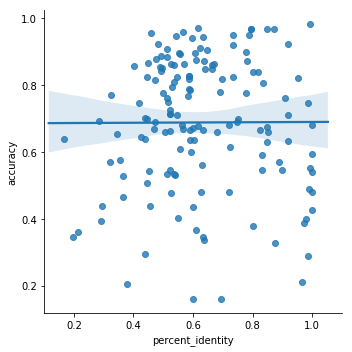

In [208]:
sns.lmplot(x='percent_identity',y='accuracy',data=seqsim)
plt.xlim(0.1,1.1)
plt.savefig('ec1_corr_percentidvsacc.png',dpi=200)

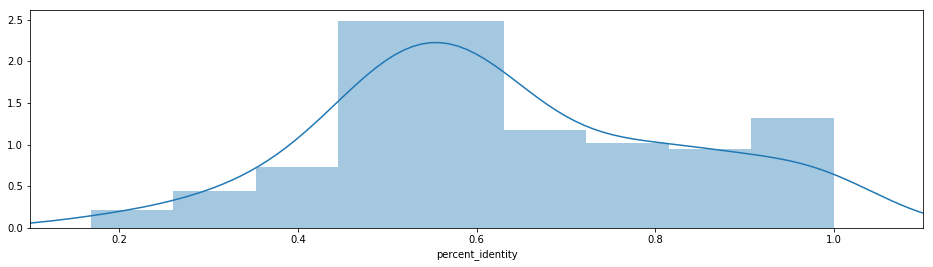

In [209]:
plt.figure(figsize=(16,4))
sns.distplot(seqsim["percent_identity"].dropna())
plt.xlim(0.1, 1.1)
plt.savefig('ec1_percentid_hist.png', dpi=200)

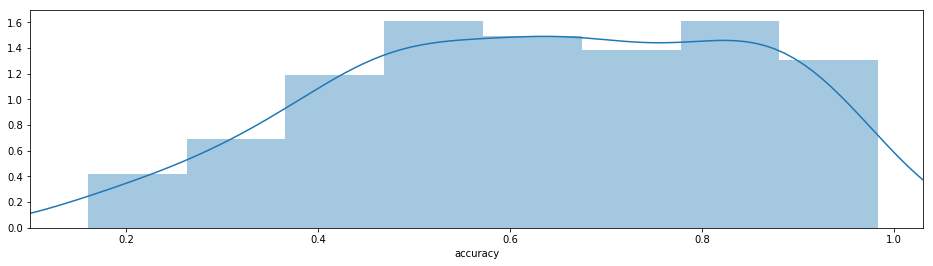

In [213]:
plt.figure(figsize=(16,4))
sns.distplot(seqsim["accuracy"].dropna())
plt.xlim(0.1,1.03)
plt.savefig('ec1_accuracy_hist.png')

In [190]:
from scipy.stats import pearsonr
#first number is r2, second is p-value
print(pearsonr(seqsim.dropna()['accuracy'], seqsim.dropna()['percent_identity']))

(0.003878835963395456, 0.9626820776317436)


# percent annotated by mifaser

In [280]:
from pathlib import Path
folders = [f for f in Path('/Users/adrienne/Projects/LanguageofLife/TransferLearningTasks/EC1/Interpretation/mifaser_results/').iterdir()]


In [242]:
folders[0].stem.split('_')[0]

'ERR598963'

In [281]:
root = '/Users/adrienne/Projects/LanguageofLife/TransferLearningTasks/EC1/Interpretation/mifaser_results/'
analysis = pd.read_csv(root+'ERR3589586_cut20M/analysis.tsv',sep='\t',names=['ec','count'])
analysis.head()

,ec,count
0,571188,15415
1,1.1.1.1,32
2,1.1.1.2,82
3,1.1.1.6,2
4,1.1.1.18,324


In [282]:
ec1s = [x.split('.')[0] for x in analysis['ec']]
analysis['ec_1'] = ec1s

In [283]:
analysis.head()

,ec,count,ec_1
0,571188,15415,571188
1,1.1.1.1,32,1
2,1.1.1.2,82,1
3,1.1.1.6,2,1
4,1.1.1.18,324,1


In [284]:
num_annotated = analysis['count'].sum()
num_annotated

571188

In [285]:
oxidos = analysis[analysis['ec_1']=='1']
oxidos.head()

,ec,count,ec_1
1,1.1.1.1,32,1
2,1.1.1.2,82,1
3,1.1.1.6,2,1
4,1.1.1.18,324,1
5,1.1.1.22,292,1


In [286]:
num_oxidos = oxidos['count'].sum()
num_oxidos

118289

In [287]:
def get_stats(folder):
    srr = folder.stem.split('_')[0]
    print(srr)
    analysis = pd.read_csv(str(folder)+'/analysis.tsv',sep='\t',names=['ec','count'])
    ec1s = [x.split('.')[0] for x in analysis['ec']]
    analysis['ec_1'] = ec1s
    oxidos = analysis[analysis['ec_1']=='1']
    
    num_annotated = analysis['count'].sum()
    num_oxidos = oxidos['count'].sum()
    row = [srr,num_annotated/20000000,num_oxidos/20000000]
    
    return row

In [288]:
rows = []
for folder in folders:
    if not folder.stem.startswith('.'):
        row = get_stats(folder)
        rows.append(row)
    
stats = pd.DataFrame(rows,columns=['SRR','percent_annotated','percent_oxidos'])

ERR598963
ERR3589586
ERR599105
ERR599052
ERR599176
ERR599076
ERR599115
ERR599048
ERR599039
ERR599125
ERR599020
ERR598981
ERR598964
ERR3589593
ERR598989
ERR599063


In [289]:
stats

,SRR,percent_annotated,percent_oxidos
0,ERR598963,0.018274,0.003392
1,ERR3589586,0.028559,0.005914
2,ERR599105,0.016069,0.003836
3,ERR599052,0.012741,0.002548
4,ERR599176,0.027172,0.004703
5,ERR599076,0.018800,0.002942
6,ERR599115,0.010099,0.001629
7,ERR599048,0.018757,0.003852
8,ERR599039,0.023412,0.004649
9,ERR599125,0.015060,0.002454


# percent annotated by mgrast

In [304]:
rast = pd.read_csv('mgrast_results/tara_percent_annotated_mgrast.csv')
rast['percent_annotated_full'] = rast['annotated protein']/(20000000-rast['failed qc'])
rast.sort_values('percent_annotated_full')

,SRR,failed qc,predicted feature,unknown protein,annotated protein,ribosomal rna,percent_annotated,percent_annotated_full
10,ERR599125,626264.0,17380761.0,12104800.0,5173535.0,102426.0,0.297659,0.267039
13,ERR599105,488799.0,17271688.0,11770067.0,5442685.0,58936.0,0.315122,0.278952
14,ERR598963,406223.0,17522905.0,11788956.0,5674293.0,59656.0,0.323821,0.289597
7,ERR3589593,450946.0,17493446.0,11744989.0,5676597.0,71860.0,0.324499,0.290377
3,ERR599020,441375.0,17655613.0,11712976.0,5892914.0,49723.0,0.333770,0.301295
5,ERR598964,462335.0,17573236.0,11611374.0,5925174.0,36688.0,0.337170,0.303269
0,ERR599048,483504.0,17554261.0,11514325.0,5986265.0,53671.0,0.341015,0.306728
4,ERR599115,486427.0,17590813.0,11354115.0,6196025.0,40673.0,0.352231,0.317524
2,ERR599076,518972.0,17905993.0,11627573.0,6244954.0,33466.0,0.348763,0.320566
8,ERR598981,552527.0,17894190.0,11406934.0,6449538.0,37718.0,0.360426,0.331639


In [305]:
fn = pd.read_csv('mgrast_results/meta15_functioncounts.txt',sep='\t')
fn.head()

,level1,level2,level3,function,ERR599063,ERR599115,ERR599105,ERR3589586,ERR599052,ERR598981,ERR599048,ERR3589593,ERR598964,ERR599020,ERR599125,ERR598963,ERR598989,ERR599076,ERR599176
0,Metabolism,Biosynthesis of Other Secondary Metabolites,00941 Flavonoid biosynthesis [PATH:ko00941],6DCS; 6'-deoxychalcone synthase [EC:2.3.1.170],822,125,135,0,988,219,172,151,197,248,161,176,653,0,97
1,Organismal Systems,Immune system,04610 Complement and coagulation cascades [PAT...,A2M; alpha-2-macroglobulin,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1
2,Metabolism,Carbohydrate metabolism,00650 Butanoate metabolism [PATH:ko00650],"AACS, acsA; acetoacetyl-CoA synthetase [EC:6.2...",3054,3776,1836,8,2837,5357,2535,3000,4104,3848,3158,3303,3207,7,3806
3,Metabolism,Amino acid metabolism,00300 Lysine biosynthesis [PATH:ko00300],"AADAT, KAT2; kynurenine/2-aminoadipate aminotr...",0,0,0,0,0,0,1,1,0,2,0,5,4,0,2
4,Metabolism,Amino acid metabolism,00380 Tryptophan metabolism [PATH:ko00380],AAO1_2; indole-3-acetaldehyde oxidase [EC:1.2....,1,1,1,0,0,1,0,1,2,0,0,2,0,0,0


In [312]:
fn['function'][0].split('[EC:')[-1].split('.')[0]

'2'

In [319]:
fn['function'][0].split('[EC:')[-1].split(']')[0]

'2.3.1.170'

In [320]:
ec_1 = [x.split('[EC:')[-1].split('.')[0] for x in fn['function']]
ecs = [x.split('[EC:')[-1].split(']')[0] for x in fn['function']]
fn['ec number'] = ecs
fn['ec_1'] = ec_1
fn.head()

,level1,level2,level3,function,ERR599063,ERR599115,ERR599105,ERR3589586,ERR599052,ERR598981,...,ERR3589593,ERR598964,ERR599020,ERR599125,ERR598963,ERR598989,ERR599076,ERR599176,ec_1,ec number
0,Metabolism,Biosynthesis of Other Secondary Metabolites,00941 Flavonoid biosynthesis [PATH:ko00941],6DCS; 6'-deoxychalcone synthase [EC:2.3.1.170],822,125,135,0,988,219,...,151,197,248,161,176,653,0,97,2,2.3.1.170
1,Organismal Systems,Immune system,04610 Complement and coagulation cascades [PAT...,A2M; alpha-2-macroglobulin,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,A2M; alpha-2-macroglobulin,A2M; alpha-2-macroglobulin
2,Metabolism,Carbohydrate metabolism,00650 Butanoate metabolism [PATH:ko00650],"AACS, acsA; acetoacetyl-CoA synthetase [EC:6.2...",3054,3776,1836,8,2837,5357,...,3000,4104,3848,3158,3303,3207,7,3806,6,6.2.1.16
3,Metabolism,Amino acid metabolism,00300 Lysine biosynthesis [PATH:ko00300],"AADAT, KAT2; kynurenine/2-aminoadipate aminotr...",0,0,0,0,0,0,...,1,0,2,0,5,4,0,2,2,2.6.1.7 2.6.1.39
4,Metabolism,Amino acid metabolism,00380 Tryptophan metabolism [PATH:ko00380],AAO1_2; indole-3-acetaldehyde oxidase [EC:1.2....,1,1,1,0,0,1,...,1,2,0,0,2,0,0,0,1,1.2.3.7


In [321]:
ec1 = fn[fn['ec_1']=='1']
print(len(ec1))
ec1.head()

733


,level1,level2,level3,function,ERR599063,ERR599115,ERR599105,ERR3589586,ERR599052,ERR598981,...,ERR3589593,ERR598964,ERR599020,ERR599125,ERR598963,ERR598989,ERR599076,ERR599176,ec_1,ec number
4,Metabolism,Amino acid metabolism,00380 Tryptophan metabolism [PATH:ko00380],AAO1_2; indole-3-acetaldehyde oxidase [EC:1.2....,1,1,1,0,0,1,...,1,2,0,0,2,0,0,0,1,1.2.3.7
5,Metabolism,Metabolism of terpenoids and polyketides,00906 Carotenoid biosynthesis [PATH:ko00906],AAO3; abscisic-aldehyde oxidase [EC:1.2.3.14],0,3,0,0,0,4,...,8,5,3,2,2,0,0,2,1,1.2.3.14
7,Metabolism,Amino acid metabolism,00300 Lysine biosynthesis [PATH:ko00300],AASS; alpha-aminoadipic semialdehyde synthase ...,22,19,11,0,17,14,...,27,11,13,14,27,24,0,35,1,1.5.1.8 1.5.1.9
8,Metabolism,Metabolism of terpenoids and polyketides,00906 Carotenoid biosynthesis [PATH:ko00906],ABA2; xanthoxin dehydrogenase [EC:1.1.1.288],1,2,3,3,2,1,...,2,0,1,1,1,1,0,1,1,1.1.1.288
109,Metabolism,Amino acid metabolism,00330 Arginine and proline metabolism [PATH:ko...,"ABP1, AOC1; diamine oxidase [EC:1.4.3.22]",0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,1,1.4.3.22


In [329]:
ec1_counts = pd.DataFrame(ec1.iloc[:,4:-2].sum(),columns=['count_oxido'])
ec1_counts['SRR'] = ec1_counts.index
ec1_counts

,count_oxido,SRR
ERR599063,719934,ERR599063
ERR599115,544068,ERR599115
ERR599105,452269,ERR599105
ERR3589586,3180,ERR3589586
ERR599052,697606,ERR599052
ERR598981,621365,ERR598981
ERR599048,536862,ERR599048
ERR3589593,525980,ERR3589593
ERR598964,569859,ERR598964
ERR599020,599512,ERR599020


In [331]:
merge_mgrast = rast.merge(ec1_counts,on='SRR')
print(len(merge_mgrast))
merge_mgrast

15


,SRR,failed qc,predicted feature,unknown protein,annotated protein,ribosomal rna,percent_annotated,percent_annotated_full,count_oxido
0,ERR599048,483504.0,17554261.0,11514325.0,5986265.0,53671.0,0.341015,0.306728,536862
1,ERR598989,382213.0,17802108.0,10374938.0,7377682.0,49488.0,0.414427,0.376071,712899
2,ERR599076,518972.0,17905993.0,11627573.0,6244954.0,33466.0,0.348763,0.320566,2093
3,ERR599020,441375.0,17655613.0,11712976.0,5892914.0,49723.0,0.333770,0.301295,599512
4,ERR599115,486427.0,17590813.0,11354115.0,6196025.0,40673.0,0.352231,0.317524,544068
5,ERR598964,462335.0,17573236.0,11611374.0,5925174.0,36688.0,0.337170,0.303269,569859
6,ERR599063,505457.0,17812084.0,9911389.0,7857631.0,43064.0,0.441140,0.403068,719934
7,ERR3589593,450946.0,17493446.0,11744989.0,5676597.0,71860.0,0.324499,0.290377,525980
8,ERR598981,552527.0,17894190.0,11406934.0,6449538.0,37718.0,0.360426,0.331639,621365
9,ERR599176,1352315.0,16638917.0,7135474.0,9371939.0,131504.0,0.563254,0.502579,751232


In [332]:
merge_mgrast['percent_oxido'] = merge_mgrast['count_oxido']/(20000000-merge_mgrast['failed qc'])
merge_mgrast

,SRR,failed qc,predicted feature,unknown protein,annotated protein,ribosomal rna,percent_annotated,percent_annotated_full,count_oxido,percent_oxido
0,ERR599048,483504.0,17554261.0,11514325.0,5986265.0,53671.0,0.341015,0.306728,536862,0.027508
1,ERR598989,382213.0,17802108.0,10374938.0,7377682.0,49488.0,0.414427,0.376071,712899,0.036339
2,ERR599076,518972.0,17905993.0,11627573.0,6244954.0,33466.0,0.348763,0.320566,2093,0.000107
3,ERR599020,441375.0,17655613.0,11712976.0,5892914.0,49723.0,0.333770,0.301295,599512,0.030652
4,ERR599115,486427.0,17590813.0,11354115.0,6196025.0,40673.0,0.352231,0.317524,544068,0.027882
5,ERR598964,462335.0,17573236.0,11611374.0,5925174.0,36688.0,0.337170,0.303269,569859,0.029167
6,ERR599063,505457.0,17812084.0,9911389.0,7857631.0,43064.0,0.441140,0.403068,719934,0.036930
7,ERR3589593,450946.0,17493446.0,11744989.0,5676597.0,71860.0,0.324499,0.290377,525980,0.026906
8,ERR598981,552527.0,17894190.0,11406934.0,6449538.0,37718.0,0.360426,0.331639,621365,0.031951
9,ERR599176,1352315.0,16638917.0,7135474.0,9371939.0,131504.0,0.563254,0.502579,751232,0.040286


# classifier results

In [333]:
results = pd.read_csv('classifier_results/EC1_predictions_summary.csv')
results

,SRR,percent_ec1
0,ERR598989,0.182063
1,ERR599039,0.184558
2,ERR599020,0.187380
3,ERR3589593,0.184745
4,ERR599048,0.185329
5,ERR599076,0.206118
6,ERR599063,0.181815
7,ERR598964,0.197463
8,ERR599052,0.185898
9,ERR599125,0.192314


# merge with metadata

In [334]:
meta = pd.read_csv('TARA_sample_metadata.csv')
meta.head()

,SRA read accession,Lat,Lon,Ocean region,Depth category,depth_cat,Depth (m),Temp (°C),Oxygen (umol/kg),OMZ?,TARA Station
0,ERR598981,-12.93,-96.12,Pacific,MES,OMZ,175.3,13.0,0.7,Yes,100
1,ERR599063,-12.99,-95.99,Pacific,SRF,SRF,5.5,25.3,200.2,-,100
2,ERR599115,35.31,-127.74,Pacific,MES,OMZ,644.6,4.9,8.6,Yes,133
3,ERR599052,35.41,-127.74,Pacific,SRF,SRF,5.5,19.2,224.4,-,133
4,ERR599020,-1.87,-84.62,Pacific,MES,OMZ,376.9,10.3,1.3,Yes,110


In [341]:
m1 = meta.merge(results,left_on='SRA read accession',right_on='SRR')
m1.drop(labels='SRR',axis=1,inplace=True)
m1.rename(columns={'percent_ec1': 'percent_oxido_classifier'},inplace=True)
m1.head()


,SRA read accession,Lat,Lon,Ocean region,Depth category,depth_cat,Depth (m),Temp (°C),Oxygen (umol/kg),OMZ?,TARA Station,percent_oxido_classifier
0,ERR598981,-12.93,-96.12,Pacific,MES,OMZ,175.3,13.0,0.7,Yes,100,0.202250
1,ERR599063,-12.99,-95.99,Pacific,SRF,SRF,5.5,25.3,200.2,-,100,0.181815
2,ERR599115,35.31,-127.74,Pacific,MES,OMZ,644.6,4.9,8.6,Yes,133,0.200113
3,ERR599052,35.41,-127.74,Pacific,SRF,SRF,5.5,19.2,224.4,-,133,0.185898
4,ERR599020,-1.87,-84.62,Pacific,MES,OMZ,376.9,10.3,1.3,Yes,110,0.187380


In [342]:
m2 = m1.merge(merge_mgrast[['SRR','percent_annotated_full','percent_oxido']],left_on='SRA read accession',right_on='SRR')
m2.drop(labels='SRR',axis=1,inplace=True)
m2.rename(columns={'percent_annotated_full': 'percent_annotated_mgrast','percent_oxido':'percent_oxido_mgrast'},inplace=True)
m2.head()

,SRA read accession,Lat,Lon,Ocean region,Depth category,depth_cat,Depth (m),Temp (°C),Oxygen (umol/kg),OMZ?,TARA Station,percent_oxido_classifier,percent_annotated_mgrast,percent_oxido_mgrast
0,ERR598981,-12.93,-96.12,Pacific,MES,OMZ,175.3,13.0,0.7,Yes,100,0.202250,0.331639,0.031951
1,ERR599063,-12.99,-95.99,Pacific,SRF,SRF,5.5,25.3,200.2,-,100,0.181815,0.403068,0.036930
2,ERR599115,35.31,-127.74,Pacific,MES,OMZ,644.6,4.9,8.6,Yes,133,0.200113,0.317524,0.027882
3,ERR599052,35.41,-127.74,Pacific,SRF,SRF,5.5,19.2,224.4,-,133,0.185898,0.368615,0.035761
4,ERR599020,-1.87,-84.62,Pacific,MES,OMZ,376.9,10.3,1.3,Yes,110,0.187380,0.301295,0.030652


In [343]:
m3 = m2.merge(stats,left_on='SRA read accession',right_on='SRR')
m3.drop(labels='SRR',axis=1,inplace=True)
m3.rename(columns={'percent_annotated': 'percent_annotated_mifaser','percent_oxidos':'percent_oxido_mifaser'},inplace=True)
m3.head()

,SRA read accession,Lat,Lon,Ocean region,Depth category,depth_cat,Depth (m),Temp (°C),Oxygen (umol/kg),OMZ?,TARA Station,percent_oxido_classifier,percent_annotated_mgrast,percent_oxido_mgrast,percent_annotated_mifaser,percent_oxido_mifaser
0,ERR598981,-12.93,-96.12,Pacific,MES,OMZ,175.3,13.0,0.7,Yes,100,0.202250,0.331639,0.031951,0.021667,0.003408
1,ERR599063,-12.99,-95.99,Pacific,SRF,SRF,5.5,25.3,200.2,-,100,0.181815,0.403068,0.036930,0.001707,0.000353
2,ERR599115,35.31,-127.74,Pacific,MES,OMZ,644.6,4.9,8.6,Yes,133,0.200113,0.317524,0.027882,0.010099,0.001629
3,ERR599052,35.41,-127.74,Pacific,SRF,SRF,5.5,19.2,224.4,-,133,0.185898,0.368615,0.035761,0.012741,0.002548
4,ERR599020,-1.87,-84.62,Pacific,MES,OMZ,376.9,10.3,1.3,Yes,110,0.187380,0.301295,0.030652,0.019407,0.003346


In [344]:
m3.sort_values('percent_oxido_classifier')

,SRA read accession,Lat,Lon,Ocean region,Depth category,depth_cat,Depth (m),Temp (°C),Oxygen (umol/kg),OMZ?,TARA Station,percent_oxido_classifier,percent_annotated_mgrast,percent_oxido_mgrast,percent_annotated_mifaser,percent_oxido_mifaser
8,ERR599105,-8.78,-17.91,Atlantic,SRF,SRF,5.8,25.0,199.1,-,72,0.163968,0.278952,0.023180,0.016069,0.003836
1,ERR599063,-12.99,-95.99,Pacific,SRF,SRF,5.5,25.3,200.2,-,100,0.181815,0.403068,0.036930,0.001707,0.000353
6,ERR598989,14.20,-116.63,Pacific,SRF,SRF,5.4,26.4,195.1,-,137,0.182063,0.376071,0.036339,0.024079,0.004829
10,ERR598963,34.10,-49.89,Atlantic,SRF,SRF,5.5,18.7,220.2,-,149,0.183043,0.289597,0.029368,0.018274,0.003392
13,ERR3589593,76.12,1.36,Polar,MES,MES,490.5,0.1,315.4,No,163,0.184745,0.290377,0.026906,0.018158,0.002944
7,ERR599048,-8.80,-17.91,Atlantic,MES,MES,792.7,4.7,143.2,No,72,0.185329,0.306728,0.027508,0.018757,0.003852
3,ERR599052,35.41,-127.74,Pacific,SRF,SRF,5.5,19.2,224.4,-,133,0.185898,0.368615,0.035761,0.012741,0.002548
12,ERR599176,-62.03,-49.54,Polar,SRF,SRF,5.9,0.7,343.4,-,85,0.186171,0.502579,0.040286,0.027172,0.004703
4,ERR599020,-1.87,-84.62,Pacific,MES,OMZ,376.9,10.3,1.3,Yes,110,0.187380,0.301295,0.030652,0.019407,0.003346
11,ERR599125,-61.98,-49.45,Polar,MES,MES,783.8,0.5,203.8,No,85,0.192314,0.267039,0.022186,0.015060,0.002454


In [345]:
m3.to_csv('classifier_annotation_comparison_withmetadata.csv',index=False)

6.805277223182836 0.02164593020198755


,SRA read accession,Lat,Lon,Ocean region,Depth category,depth_cat,Depth (m),Temp (°C),Oxygen (umol/kg),OMZ?,TARA Station,percent_oxido_classifier,percent_annotated_mgrast,percent_oxido_mgrast,percent_annotated_mifaser,percent_oxido_mifaser,abs_lat
11,ERR599125,-61.98,-49.45,Polar,MES,MES,783.8,0.5,203.8,No,85,0.192314,0.267039,0.022186,0.015060,0.002454,61.98
8,ERR599105,-8.78,-17.91,Atlantic,SRF,SRF,5.8,25.0,199.1,-,72,0.163968,0.278952,0.023180,0.016069,0.003836,8.78
10,ERR598963,34.10,-49.89,Atlantic,SRF,SRF,5.5,18.7,220.2,-,149,0.183043,0.289597,0.029368,0.018274,0.003392,34.10
13,ERR3589593,76.12,1.36,Polar,MES,MES,490.5,0.1,315.4,No,163,0.184745,0.290377,0.026906,0.018158,0.002944,76.12
4,ERR599020,-1.87,-84.62,Pacific,MES,OMZ,376.9,10.3,1.3,Yes,110,0.187380,0.301295,0.030652,0.019407,0.003346,1.87
9,ERR598964,34.10,-49.78,Atlantic,MES,MES,734.3,10.6,155.2,No,149,0.197463,0.303269,0.029167,0.017322,0.002829,34.10
7,ERR599048,-8.80,-17.91,Atlantic,MES,MES,792.7,4.7,143.2,No,72,0.185329,0.306728,0.027508,0.018757,0.003852,8.80
2,ERR599115,35.31,-127.74,Pacific,MES,OMZ,644.6,4.9,8.6,Yes,133,0.200113,0.317524,0.027882,0.010099,0.001629,35.31
5,ERR599076,14.17,-116.66,Pacific,MES,OMZ,371.0,8.9,0.6,Yes,137,0.206118,0.320566,0.000107,0.018800,0.002942,14.17
0,ERR598981,-12.93,-96.12,Pacific,MES,OMZ,175.3,13.0,0.7,Yes,100,0.202250,0.331639,0.031951,0.021667,0.003408,12.93


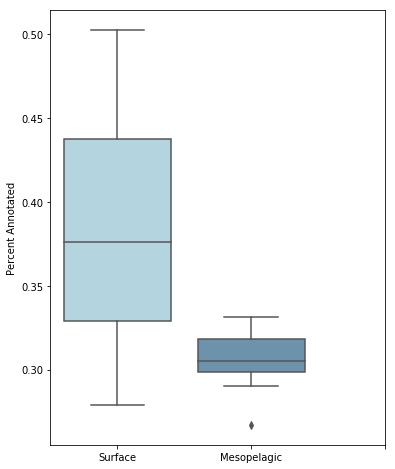

In [548]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="Depth category", y="percent_annotated_mgrast", data=m3, order=['SRF','MES'],palette=['#ADD8E6','#6294B7'])
plt.ylabel('Percent Annotated')
plt.xlabel('')
plt.xticks([0,1,2],('Surface', 'Mesopelagic'),rotation=0)

srf = m3[m3['Depth category']=='SRF']['percent_annotated_mgrast']
mes = m3[m3['Depth category']=='MES']['percent_annotated_mgrast']
F,p = anova(srf,mes)
print(F,p)

m3.sort_values('percent_annotated_mgrast')

0.07332244813016679 0.7908109688174321


,SRA read accession,Lat,Lon,Ocean region,Depth category,depth_cat,Depth (m),Temp (°C),Oxygen (umol/kg),OMZ?,TARA Station,percent_oxido_classifier,percent_annotated_mgrast,percent_oxido_mgrast,percent_annotated_mifaser,percent_oxido_mifaser,abs_lat
1,ERR599063,-12.99,-95.99,Pacific,SRF,SRF,5.5,25.3,200.2,-,100,0.181815,0.403068,0.036930,0.001707,0.000353,12.99
2,ERR599115,35.31,-127.74,Pacific,MES,OMZ,644.6,4.9,8.6,Yes,133,0.200113,0.317524,0.027882,0.010099,0.001629,35.31
3,ERR599052,35.41,-127.74,Pacific,SRF,SRF,5.5,19.2,224.4,-,133,0.185898,0.368615,0.035761,0.012741,0.002548,35.41
11,ERR599125,-61.98,-49.45,Polar,MES,MES,783.8,0.5,203.8,No,85,0.192314,0.267039,0.022186,0.015060,0.002454,61.98
8,ERR599105,-8.78,-17.91,Atlantic,SRF,SRF,5.8,25.0,199.1,-,72,0.163968,0.278952,0.023180,0.016069,0.003836,8.78
9,ERR598964,34.10,-49.78,Atlantic,MES,MES,734.3,10.6,155.2,No,149,0.197463,0.303269,0.029167,0.017322,0.002829,34.10
13,ERR3589593,76.12,1.36,Polar,MES,MES,490.5,0.1,315.4,No,163,0.184745,0.290377,0.026906,0.018158,0.002944,76.12
10,ERR598963,34.10,-49.89,Atlantic,SRF,SRF,5.5,18.7,220.2,-,149,0.183043,0.289597,0.029368,0.018274,0.003392,34.10
7,ERR599048,-8.80,-17.91,Atlantic,MES,MES,792.7,4.7,143.2,No,72,0.185329,0.306728,0.027508,0.018757,0.003852,8.80
5,ERR599076,14.17,-116.66,Pacific,MES,OMZ,371.0,8.9,0.6,Yes,137,0.206118,0.320566,0.000107,0.018800,0.002942,14.17


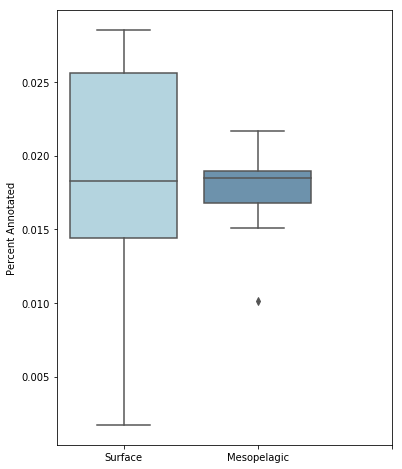

In [549]:
plt.figure(figsize=(6,8))
ax = sns.boxplot(x="Depth category", y="percent_annotated_mifaser", data=m3, order=['SRF','MES'],palette=['#ADD8E6','#6294B7'])
plt.ylabel('Percent Annotated')
plt.xlabel('')
plt.xticks([0,1,2],('Surface', 'Mesopelagic'),rotation=0)

srf = m3[m3['Depth category']=='SRF']['percent_annotated_mifaser']
mes = m3[m3['Depth category']=='MES']['percent_annotated_mifaser']
F,p = anova(srf,mes)
print(F,p)

m3.sort_values('percent_annotated_mifaser')

## average percent annotated barchart

In [433]:
oxido_means = [m3['percent_oxido_classifier'].mean(),m3['percent_oxido_mgrast'].mean(),m3['percent_oxido_mifaser'].mean()]
not_oxido_means = [1-m3['percent_oxido_classifier'].mean(),m3['percent_annotated_mgrast'].mean(),m3['percent_annotated_mifaser'].mean()]
unannotated = [0,(1-m3['percent_oxido_mgrast'].mean()-m3['percent_annotated_mgrast'].mean()),(1-m3['percent_oxido_mifaser'].mean()-m3['percent_annotated_mifaser'].mean())]
oxido_std = [m3['percent_oxido_classifier'].std(),m3['percent_oxido_mgrast'].std(),m3['percent_oxido_mifaser'].std()]
not_oxido_std = [1-m3['percent_oxido_classifier'].std(),m3['percent_annotated_mgrast'].std(),m3['percent_annotated_mifaser'].std()]
print(oxido_means,not_oxido_means,unannotated)

[0.18900274666666667, 0.026559537539509206, 0.003265413333333333] [0.8109972533333334, 0.34194750749398306, 0.01785809] [0, 0.6314929549665077, 0.9788764966666667]


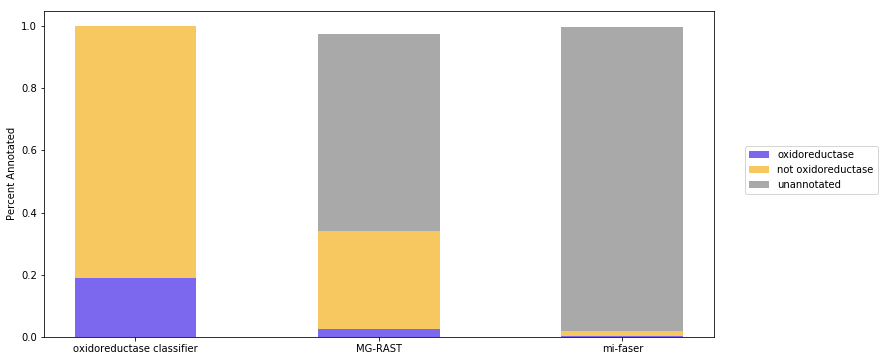

In [551]:
N = 3
menMeans = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
menStd = (2, 3, 4, 1, 2)
womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.5       # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(12,6))
p1 = plt.bar(ind, oxido_means, width, color='mediumslateblue')
p2 = plt.bar(ind, not_oxido_means, width, color='#F6C85F', bottom=oxido_means)
p3 = plt.bar(ind, unannotated, width, color='darkgray', bottom=not_oxido_means)

plt.ylabel('Percent Annotated')
#plt.title('percent annotated by method')
plt.xticks(ind, ('oxidoreductase classifier', 'MG-RAST', 'mi-faser'),rotation=0)
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0], p3[0]), ('oxidoreductase', 'not oxidoreductase', 'unannotated'), bbox_to_anchor=(1.04,0.6))
plt.savefig('Fig5c_percentannotatedoxido.png',dpi=150,bbox_inches='tight')

## depth gradient

In [351]:
from scipy.stats import f_oneway as anova

In [354]:
#test that all three cats are different
srf = m3[m3['depth_cat']=='SRF']['percent_oxido_classifier']
mes = m3[m3['depth_cat']=='MES']['percent_oxido_classifier']
omz = m3[m3['depth_cat']=='OMZ']['percent_oxido_classifier']
F,p = anova(srf,mes,omz)
print(F,p)

4.647311721087953 0.0320234182649505


In [355]:
srf = m3[m3['Depth category']=='SRF']['percent_oxido_classifier']
mes = m3[m3['Depth category']=='MES']['percent_oxido_classifier']
F,p = anova(srf,mes)
print(F,p)

6.443905128051485 0.024725229413401717


In [357]:
srf = m3[m3['depth_cat']=='SRF']['percent_oxido_classifier']
omz = m3[m3['depth_cat']=='OMZ']['percent_oxido_classifier']
F,p = anova(srf,omz)
print(F,p)

7.926228760717954 0.020199602780843016


In [421]:
mes = m3[m3['depth_cat']=='MES']['percent_oxido_classifier']
omz = m3[m3['depth_cat']=='OMZ']['percent_oxido_classifier']
srf = m3[m3['depth_cat']=='SRF']['percent_oxido_classifier']
F,p = anova(mes.append(omz),srf)
print(F,p)

6.443905128051482 0.024725229413401717


In [358]:
mes = m3[m3['depth_cat']=='MES']['percent_oxido_classifier']
omz = m3[m3['depth_cat']=='OMZ']['percent_oxido_classifier']
F,p = anova(mes,omz)
print(F,p)

3.157855343651905 0.12589216644908507


In [359]:
#both MES and OMZ are significantly different that SRF; all three are different than eachother; 
#but MES and OMZ are not significantly different

In [364]:
print(srf.mean(), '+/-', srf.std())
print(mes.mean(), '+/-', mes.std())
print(omz.mean(), '+/-', omz.std())

0.18276140714285719 +/- 0.009672866729216863
0.1899626625 +/- 0.006068539811241667
0.19896517500000002 +/- 0.00811365504386484


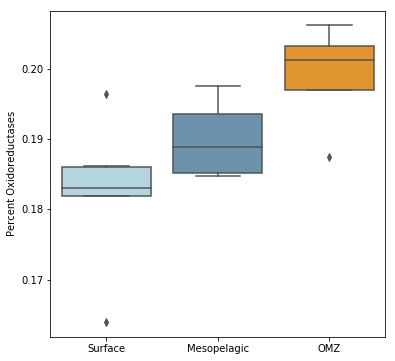

In [550]:
plt.figure(figsize=(6,6))
ax = sns.boxplot(x="depth_cat", y="percent_oxido_classifier", data=m3, order=['SRF','MES','OMZ'],palette=['#ADD8E6','#6294B7','#FF9912'])
plt.ylabel('Percent Oxidoreductases')
plt.xlabel('')
plt.xticks([0,1,2],('Surface', 'Mesopelagic', 'OMZ'),rotation=0)

plt.savefig('Fig5a_percoxido_by_depth.png',dpi=150)

## ocean region gradient (no significant differences)

1.1494317632506763 0.34936415947496874
0.03716099146650929 0.8501165986483635


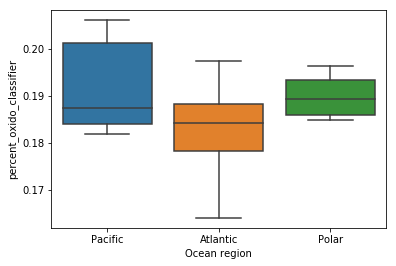

In [417]:
#what about ocean regions?
#test that all three cats are different, or that polar is different - not when depths are mixed together
pac = m3[m3['Ocean region']=='Pacific']['percent_oxido_classifier']
atl = m3[m3['Ocean region']=='Atlantic']['percent_oxido_classifier']
polar = m3[m3['Ocean region']=='Polar']['percent_oxido_classifier']
F,p = anova(pac,atl,polar)
print(F,p)
F,p = anova(pac.append(atl),polar)
print(F,p)
ax = sns.boxplot(x="Ocean region", y="percent_oxido_classifier", data=m3)


2.59328173424188 0.18958929994549759
2.827637606899451 0.15348283092535123


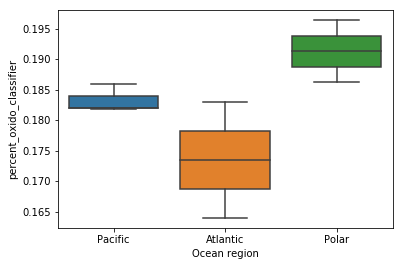

In [418]:
#or when look at just surface
srf_df = m3[m3['depth_cat']=='SRF']
pac = srf_df[srf_df['Ocean region']=='Pacific']['percent_oxido_classifier']
atl = srf_df[srf_df['Ocean region']=='Atlantic']['percent_oxido_classifier']
polar = srf_df[srf_df['Ocean region']=='Polar']['percent_oxido_classifier']
F,p = anova(pac,atl,polar)
print(F,p)
F,p = anova(pac.append(atl),polar)
print(F,p)

ax = sns.boxplot(x="Ocean region", y="percent_oxido_classifier", data=srf_df)

1.420359511702904 0.3247396239815368
1.4980145746597016 0.2668540601466966
3.157855343651905 0.12589216644908507


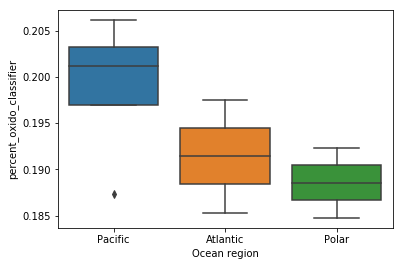

In [420]:
#or when look at just mes
mes_df = m3[m3['Depth category']=='MES']

pac = mes_df[mes_df['Ocean region']=='Pacific']['percent_oxido_classifier']
atl = mes_df[mes_df['Ocean region']=='Atlantic']['percent_oxido_classifier']
polar = mes_df[mes_df['Ocean region']=='Polar']['percent_oxido_classifier']
F,p = anova(pac,atl,polar)
print(F,p)
F,p = anova(pac.append(atl),polar)
print(F,p)
F,p = anova(pac,atl.append(polar)) #pacific is all the omz ones, also not significantly different (same as above)
print(F,p)

ax = sns.boxplot(x="Ocean region", y="percent_oxido_classifier", data=mes_df)

## latitudinal gradient

In [368]:
m3['abs_lat'] = m3['Lat'].abs()
m3.sort_values('abs_lat')

,SRA read accession,Lat,Lon,Ocean region,Depth category,depth_cat,Depth (m),Temp (°C),Oxygen (umol/kg),OMZ?,TARA Station,percent_oxido_classifier,percent_annotated_mgrast,percent_oxido_mgrast,percent_annotated_mifaser,percent_oxido_mifaser,abs_lat
4,ERR599020,-1.87,-84.62,Pacific,MES,OMZ,376.9,10.3,1.3,Yes,110,0.187380,0.301295,0.030652,0.019407,0.003346,1.87
8,ERR599105,-8.78,-17.91,Atlantic,SRF,SRF,5.8,25.0,199.1,-,72,0.163968,0.278952,0.023180,0.016069,0.003836,8.78
7,ERR599048,-8.80,-17.91,Atlantic,MES,MES,792.7,4.7,143.2,No,72,0.185329,0.306728,0.027508,0.018757,0.003852,8.80
0,ERR598981,-12.93,-96.12,Pacific,MES,OMZ,175.3,13.0,0.7,Yes,100,0.202250,0.331639,0.031951,0.021667,0.003408,12.93
1,ERR599063,-12.99,-95.99,Pacific,SRF,SRF,5.5,25.3,200.2,-,100,0.181815,0.403068,0.036930,0.001707,0.000353,12.99
5,ERR599076,14.17,-116.66,Pacific,MES,OMZ,371.0,8.9,0.6,Yes,137,0.206118,0.320566,0.000107,0.018800,0.002942,14.17
6,ERR598989,14.20,-116.63,Pacific,SRF,SRF,5.4,26.4,195.1,-,137,0.182063,0.376071,0.036339,0.024079,0.004829,14.20
9,ERR598964,34.10,-49.78,Atlantic,MES,MES,734.3,10.6,155.2,No,149,0.197463,0.303269,0.029167,0.017322,0.002829,34.10
10,ERR598963,34.10,-49.89,Atlantic,SRF,SRF,5.5,18.7,220.2,-,149,0.183043,0.289597,0.029368,0.018274,0.003392,34.10
2,ERR599115,35.31,-127.74,Pacific,MES,OMZ,644.6,4.9,8.6,Yes,133,0.200113,0.317524,0.027882,0.010099,0.001629,35.31


(0.1607305157039407, 0.5671570426972612)


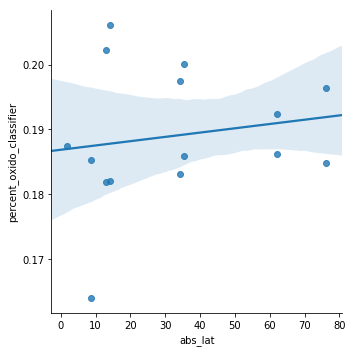

In [422]:
sns.lmplot(x='abs_lat',y='percent_oxido_classifier',data=m3)
from scipy.stats import pearsonr
#first number is r2, second is p-value
print(pearsonr(m3['abs_lat'], m3['percent_oxido_classifier']))
#no significant latitudinal trend looking at all depths together

(0.7855579879327558, 0.036301300119799366)
(-0.26103756767438263, 0.5323341220152193)


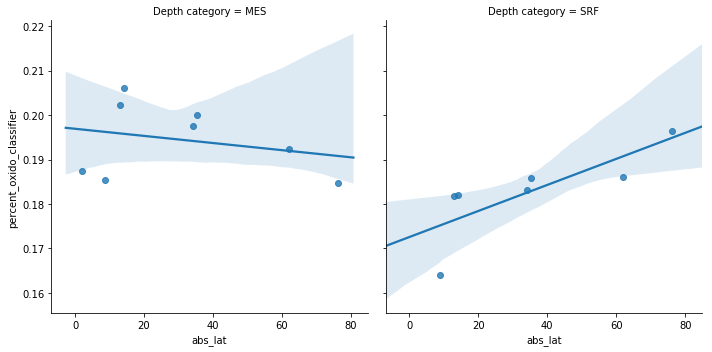

In [429]:
#but there is a significant latitudinal trend in surface waters only
sns.lmplot(x='abs_lat',y='percent_oxido_classifier',data=m3,col='Depth category')
srf = m3[m3['Depth category']=='SRF']
mes = m3[m3['Depth category']=='MES']
print(pearsonr(srf['abs_lat'], srf['percent_oxido_classifier']))
print(pearsonr(mes['abs_lat'], mes['percent_oxido_classifier']))

<Figure size 432x576 with 0 Axes>

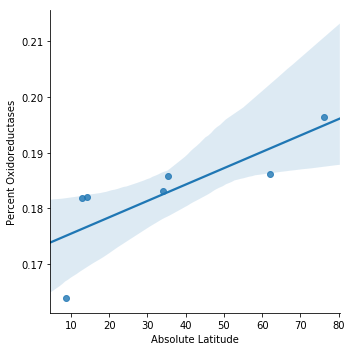

In [516]:
srf = m3[m3['Depth category']=='SRF']

plt.figure(figsize=(6,8))
ax = sns.lmplot(x='abs_lat',y='percent_oxido_classifier',data=srf)
plt.ylabel('Percent Oxidoreductases')
plt.xlabel('Absolute Latitude')

plt.savefig('Fig5b_percoxido_srf_by_lat.png',dpi=150)

(-0.6572426873972845, 0.10867657040322394)


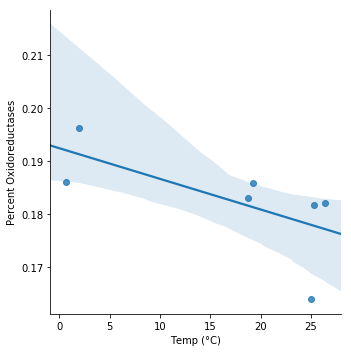

In [539]:
#a marginally significant temperature trend - but this is all due to depth I think
sns.lmplot(x='Temp (°C)',y='percent_oxido_classifier',data=srf_df)
plt.ylabel('Percent Oxidoreductases')
plt.savefig('percoxido_srf_by_temp.png',dpi=150)
print(pearsonr(srf_df['Temp (°C)'], srf_df['percent_oxido_classifier']))

(-0.6572426873972845, 0.10867657040322394)
(0.53092369336875, 0.17576955180086853)


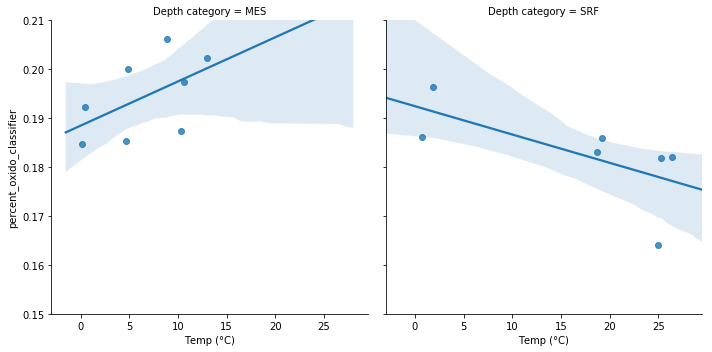

In [431]:
#yup - a similar temperature-related trend in surface waters albeit less statistically significant
sns.lmplot(x='Temp (°C)',y='percent_oxido_classifier',data=m3,col='Depth category')
plt.ylim(0.15,0.21)
print(pearsonr(srf['Temp (°C)'], srf['percent_oxido_classifier']))
print(pearsonr(mes['Temp (°C)'], mes['percent_oxido_classifier']))

(-0.4886897765155783, 0.265781638723572)


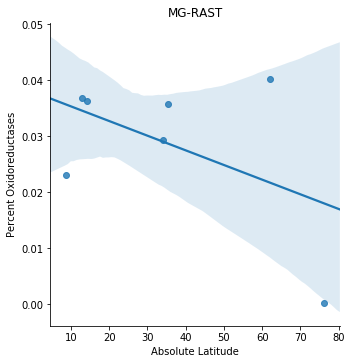

In [535]:
#note this trend goes away when look at mgrast or mifaser, no significant relationship; and the trend even reverses with mgrast
sns.lmplot(x='abs_lat',y='percent_oxido_mgrast',data=srf_df)
plt.title('MG-RAST')
plt.ylabel('Percent Oxidoreductases')
plt.xlabel('Absolute Latitude')
plt.savefig('mgrast_percoxido_srf_by_lat.png', dpi=150)

srf = m3[m3['Depth category']=='SRF']
print(pearsonr(srf['abs_lat'], srf['percent_oxido_mgrast']))

(0.5826663195134658, 0.16980930740896127)


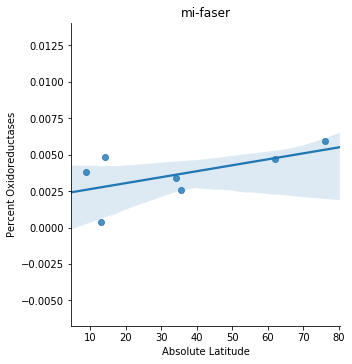

In [536]:
sns.lmplot(x='abs_lat',y='percent_oxido_mifaser',data=srf_df)
plt.title('mi-faser')
plt.ylabel('Percent Oxidoreductases')
plt.xlabel('Absolute Latitude')
plt.savefig('mifaser_percoxido_srf_by_lat.png', dpi=150)

srf = m3[m3['Depth category']=='SRF']
print(pearsonr(srf['abs_lat'], srf['percent_oxido_mifaser']))

0.3159944350609087 0.7349487747073334


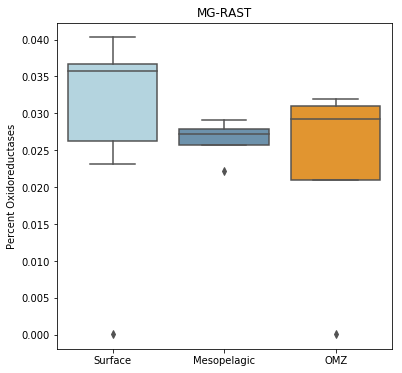

In [531]:
#and same story for the depth-related differences
plt.figure(figsize=(6,6))
ax = sns.boxplot(x="depth_cat", y="percent_oxido_mgrast", data=m3, order=['SRF','MES','OMZ'],palette=['#ADD8E6','#6294B7','#FF9912'])
plt.ylabel('Percent Oxidoreductases')
plt.title('MG-RAST')
plt.xlabel('')
plt.xticks([0,1,2],('Surface', 'Mesopelagic', 'OMZ'),rotation=0)

plt.savefig('mgrast_percoxido_by_depth.png',dpi=150)

#test that all three cats are different
srf = m3[m3['depth_cat']=='SRF']['percent_oxido_mgrast']
mes = m3[m3['depth_cat']=='MES']['percent_oxido_mgrast']
omz = m3[m3['depth_cat']=='OMZ']['percent_oxido_mgrast']
F,p = anova(srf,mes,omz)
print(F,p)

0.5365182809000791 0.5981755003898673


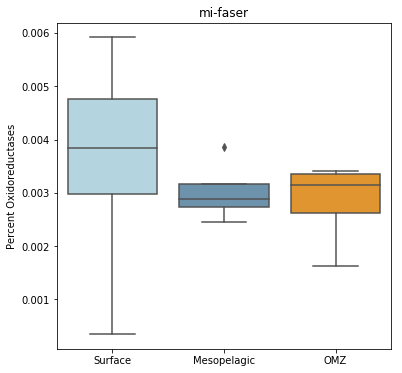

In [532]:
#and same story for the depth-related differences
plt.figure(figsize=(6,6))
ax = sns.boxplot(x="depth_cat", y="percent_oxido_mifaser", data=m3, order=['SRF','MES','OMZ'],palette=['#ADD8E6','#6294B7','#FF9912'])
plt.ylabel('Percent Oxidoreductases')
plt.title('mi-faser')
plt.xlabel('')
plt.xticks([0,1,2],('Surface', 'Mesopelagic', 'OMZ'),rotation=0)

plt.savefig('mifaser_percoxido_by_depth.png',dpi=150)

#test that all three cats are different
srf = m3[m3['depth_cat']=='SRF']['percent_oxido_mifaser']
mes = m3[m3['depth_cat']=='MES']['percent_oxido_mifaser']
omz = m3[m3['depth_cat']=='OMZ']['percent_oxido_mifaser']
F,p = anova(srf,mes,omz)
print(F,p)

# just looking again at TARA metadata...

In [396]:
om1 = pd.read_csv('OM.CompanionTables-W8.csv')
om1.head()

,PANGAEA Sample ID,Mean_Date [YY/MM/DD hh:mm]*,Mean_Lat*,Mean_Long*,Mean_Depth [m]*,Mean_Temperature [deg C]*,Mean Depth MLD Sigma [m]*,Mean_Salinity [PSU]*,Mean_Oxygen [umol/kg]*,Mean_Nitrates[umol/L]*,...,miTAG.SILVA.ace,miTAG.SILVA.Shannon,OG.Shannon,OG.Richness,OG.Evenness,FC - heterotrophs [cells/mL],FC - autotrophs [cells/mL],FC - bacteria [cells/mL],FC - picoeukaryotes [cells/mL],minimum generation time [h]
0,TARA_B100000161,4/13/10 3:21,0.00,71.64,5.5,30.5,14.0,35.1,185.2,2.6,...,3226.0,6.30,7.06,14553.0,0.736,393599.0,305984.0,699583.0,818.0,13.0
1,TARA_R100000406,4/15/10 2:38,-0.66,73.16,5.5,30.1,12.0,35.1,185.7,0.5,...,NaN,NaN,NaN,NaN,NaN,773570.0,433402.0,1206972.0,16620.0,NaN
2,TARA_R100000149,4/4/10 3:13,6.03,73.89,5.4,30.0,21.0,34.6,189.3,-1.5,...,NaN,NaN,NaN,NaN,NaN,808564.0,188746.0,997310.0,909.0,NaN
3,TARA_B100000123,4/4/10 3:13,6.03,73.89,5.4,30.0,21.0,34.6,189.3,-1.5,...,3569.0,6.51,7.09,15541.0,0.735,808564.0,188746.0,997310.0,909.0,14.0
4,TARA_Y100000114,4/19/10 7:54,-9.39,66.42,5.4,29.8,17.0,34.2,187.3,-2.2,...,NaN,NaN,NaN,NaN,NaN,313030.0,148147.0,461176.0,566.0,NaN


In [397]:
om2 = pd.read_csv('OM.CompanionTables-1.csv')
om2.head()

,Sample label [TARA_station#_environmental-feature_size-fraction],Station identifier [TARA_station#],Marine pelagic biomes (Longhurst 2007),Marine pelagic biomes (Longhurst 2007) [MRGID registered at www.marineregions.com],INSDC sample accession number(s),INSDC run accession number(s),Corresponding nucleotides data published at ENA,PANGAEA sample identifier,Corresponding contextual data published at PANGAEA,Date/Time [yyyy-mm-ddThh:mm],Latitude [degrees North],Longitude [degrees East],Sampling depth [m],Environmental Feature,Size fraction lower threshold [micrometre],Size fraction upper threshold [micrometre],Ocean and sea regions (IHO General Sea Areas 1953) [MRGID registered at www.marineregions.com]
0,TARA_004_DCM_0.22-1.6,TARA_004,Westerlies Biome,(NAST-E) North Atlantic Subtropical Gyral Prov...,ERS487936,ERR598950|ERR599095,"http://www.ebi.ac.uk/ena/data/view/ERR598950,E...",TARA_X000000368,http://www.pangaea.de/search?All&q=TARA_X00000...,2009-09-15T18:00,36.5533,-6.5669,40.0,(DCM) deep chlorophyll maximum layer (ENVO:010...,0.22,1.6,(NAO) North Atlantic Ocean [MRGID:1912]
1,TARA_004_SRF_0.22-1.6,TARA_004,Westerlies Biome,(NAST-E) North Atlantic Subtropical Gyral Prov...,ERS487899,ERR598955|ERR599003,"http://www.ebi.ac.uk/ena/data/view/ERR598955,E...",TARA_Y200000002,http://www.pangaea.de/search?All&q=TARA_Y20000...,2009-09-15T11:30,36.5533,-6.5669,5.0,(SRF) surface water layer (ENVO:00002042),0.22,1.6,(NAO) North Atlantic Ocean [MRGID:1912]
2,TARA_007_DCM_0.22-1.6,TARA_007,Westerlies Biome,"(MEDI) Mediterranean Sea, Black Sea Province [...",ERS477953,ERR315856,http://www.ebi.ac.uk/ena/data/view/ERR315856,TARA_A200000159,http://www.pangaea.de/search?All&q=TARA_A20000...,2009-09-23T16:08,37.0541,1.9478,42.0,(DCM) deep chlorophyll maximum layer (ENVO:010...,0.22,1.6,(MS) Mediterranean Sea [MRGID:1905]
3,TARA_007_SRF_0.22-1.6,TARA_007,Westerlies Biome,"(MEDI) Mediterranean Sea, Black Sea Province [...",ERS477931,ERR315857,http://www.ebi.ac.uk/ena/data/view/ERR315857,TARA_A200000113,http://www.pangaea.de/search?All&q=TARA_A20000...,2009-09-23T12:50,37.0510,1.9378,5.0,(SRF) surface water layer (ENVO:00002042),0.22,1.6,(MS) Mediterranean Sea [MRGID:1905]
4,TARA_009_DCM_0.22-1.6,TARA_009,Westerlies Biome,"(MEDI) Mediterranean Sea, Black Sea Province [...",ERS488147,ERR594315|ERR594329,"http://www.ebi.ac.uk/ena/data/view/ERR594315,E...",TARA_X000001036,http://www.pangaea.de/search?All&q=TARA_X00000...,2009-09-28T16:59,39.0609,5.9422,55.0,(DCM) deep chlorophyll maximum layer (ENVO:010...,0.22,1.6,(MS) Mediterranean Sea [MRGID:1905]


In [398]:
merge = om1.merge(om2,left_on='PANGAEA Sample ID',right_on='PANGAEA sample identifier')
merge.head()

,PANGAEA Sample ID,Mean_Date [YY/MM/DD hh:mm]*,Mean_Lat*,Mean_Long*,Mean_Depth [m]*,Mean_Temperature [deg C]*,Mean Depth MLD Sigma [m]*,Mean_Salinity [PSU]*,Mean_Oxygen [umol/kg]*,Mean_Nitrates[umol/L]*,...,PANGAEA sample identifier,Corresponding contextual data published at PANGAEA,Date/Time [yyyy-mm-ddThh:mm],Latitude [degrees North],Longitude [degrees East],Sampling depth [m],Environmental Feature,Size fraction lower threshold [micrometre],Size fraction upper threshold [micrometre],Ocean and sea regions (IHO General Sea Areas 1953) [MRGID registered at www.marineregions.com]
0,TARA_B100000161,4/13/10 3:21,0.00,71.64,5.5,30.5,14.0,35.1,185.2,2.6,...,TARA_B100000161,http://www.pangaea.de/search?All&q=TARA_B10000...,2010-04-13T03:21,0.0033,71.6428,5.0,(SRF) surface water layer (ENVO:00002042),0.22,1.60,(IO) Indian Ocean [MRGID:1904]
1,TARA_R100000406,4/15/10 2:38,-0.66,73.16,5.5,30.1,12.0,35.1,185.7,0.5,...,TARA_R100000406,http://www.pangaea.de/search?All&q=TARA_R10000...,2010-04-15T02:01,-0.6625,73.1610,5.0,(SRF) surface water layer (ENVO:00002042),<,0.22,(IO) Indian Ocean [MRGID:1904]
2,TARA_R100000149,4/4/10 3:13,6.03,73.89,5.4,30.0,21.0,34.6,189.3,-1.5,...,TARA_R100000149,http://www.pangaea.de/search?All&q=TARA_R10000...,2010-04-04T02:47,6.0001,73.8955,5.0,(SRF) surface water layer (ENVO:00002042),<,0.22,(IO) Indian Ocean [MRGID:1904]
3,TARA_B100000123,4/4/10 3:13,6.03,73.89,5.4,30.0,21.0,34.6,189.3,-1.5,...,TARA_B100000123,http://www.pangaea.de/search?All&q=TARA_B10000...,2010-04-04T02:47,6.0001,73.8955,5.0,(SRF) surface water layer (ENVO:00002042),0.22,1.60,(IO) Indian Ocean [MRGID:1904]
4,TARA_Y100000114,4/19/10 7:54,-9.39,66.42,5.4,29.8,17.0,34.2,187.3,-2.2,...,TARA_Y100000114,http://www.pangaea.de/search?All&q=TARA_Y10000...,2010-04-19T07:56,-9.3921,66.4228,5.0,(SRF) surface water layer (ENVO:00002042),0.1,0.22,(IO) Indian Ocean [MRGID:1904]


In [403]:
prok = merge[merge['Size fraction lower threshold [micrometre]']=='0.22']
prok = prok[prok['Size fraction upper threshold [micrometre]']==3.00]
prok.sort_values('Mean_Oxygen [umol/kg]*')

,PANGAEA Sample ID,Mean_Date [YY/MM/DD hh:mm]*,Mean_Lat*,Mean_Long*,Mean_Depth [m]*,Mean_Temperature [deg C]*,Mean Depth MLD Sigma [m]*,Mean_Salinity [PSU]*,Mean_Oxygen [umol/kg]*,Mean_Nitrates[umol/L]*,...,PANGAEA sample identifier,Corresponding contextual data published at PANGAEA,Date/Time [yyyy-mm-ddThh:mm],Latitude [degrees North],Longitude [degrees East],Sampling depth [m],Environmental Feature,Size fraction lower threshold [micrometre],Size fraction upper threshold [micrometre],Ocean and sea regions (IHO General Sea Areas 1953) [MRGID registered at www.marineregions.com]
209,TARA_B100001971,12/3/11 16:31,14.17,-116.66,371.0,8.9,17.0,34.6,0.6,35.7,...,TARA_B100001971,http://www.pangaea.de/search?All&q=TARA_B10000...,2011-12-03T14:31:20,14.2025,-116.6433,375.0,(MES) mesopelagic zone (ENVO:00000213),0.22,3.0,(NPO) North Pacific Ocean [MRGID:1908]
194,TARA_B100000959,4/16/11 16:09,-12.93,-96.12,175.3,13.0,35.0,34.8,0.7,21.1,...,TARA_B100000959,http://www.pangaea.de/search?All&q=TARA_B10000...,2011-04-16T13:03:08,-12.9794,-96.0232,177.0,(DCM) deep chlorophyll maximum layer (ENVO:010...,0.22,3.0,(SPO) South Pacific Ocean [MRGID:1910]
211,TARA_B100002003,12/11/11 22:51,6.37,-103.07,444.9,8.2,24.0,34.6,0.8,36.9,...,TARA_B100002003,http://www.pangaea.de/search?All&q=TARA_B10000...,2011-12-11T20:37:22,6.3559,-103.0598,450.0,(MES) mesopelagic zone (ENVO:00000213),0.22,3.0,(NPO) North Pacific Ocean [MRGID:1908]
205,TARA_B100001079,5/22/11 17:56,-1.87,-84.62,376.9,10.3,22.0,34.8,1.3,34.6,...,TARA_B100001079,http://www.pangaea.de/search?All&q=TARA_B10000...,2011-05-22T13:20,-1.8902,-84.6141,380.0,(MES) mesopelagic zone (ENVO:00000213) & marin...,0.22,3.0,(SPO) South Pacific Ocean [MRGID:1910]
201,TARA_B100000929,5/13/11 19:44,2.07,-84.54,376.4,11.3,9.0,34.8,2.5,33.9,...,TARA_B100000929,http://www.pangaea.de/search?All&q=TARA_B10000...,2011-05-13T16:08:58,2.0649,-84.5546,380.0,(MES) mesopelagic zone (ENVO:00000213) & marin...,0.22,3.0,(NPO) North Pacific Ocean [MRGID:1908]
203,TARA_B100000586,6/1/11 18:24,-16.96,-100.66,347.1,10.9,67.0,34.7,3.2,30.4,...,TARA_B100000586,http://www.pangaea.de/search?All&q=TARA_B10000...,2011-06-01T16:00:59,-16.9486,-100.6715,350.0,(MES) mesopelagic zone (ENVO:00000213) & marin...,0.22,3.0,(SPO) South Pacific Ocean [MRGID:1910]
208,TARA_B100000953,4/22/11 14:16,-5.27,-85.22,475.6,9.2,18.0,34.7,4.4,40.0,...,TARA_B100000953,http://www.pangaea.de/search?All&q=TARA_B10000...,2011-04-22T12:08:28,-5.2610,-85.1678,480.0,(MES) mesopelagic zone (ENVO:00000213) & marin...,0.22,3.0,(SPO) South Pacific Ocean [MRGID:1910]
229,TARA_B100001105,10/19/11 21:20,35.31,-127.74,644.6,4.9,10.0,34.3,8.6,44.1,...,TARA_B100001105,http://www.pangaea.de/search?All&q=TARA_B10000...,2011-10-19T19:27:16,35.2698,-127.7268,650.0,(MES) mesopelagic zone (ENVO:00000213),0.22,3.0,(NPO) North Pacific Ocean [MRGID:1908]
217,TARA_B100000678,7/27/11 23:48,-8.99,-139.23,594.6,7.2,71.0,34.6,38.1,42.5,...,TARA_B100000678,http://www.pangaea.de/search?All&q=TARA_B10000...,2011-07-27T19:28:43,-8.9729,-139.2393,600.0,(MES) mesopelagic zone (ENVO:00000213),0.22,3.0,(SPO) South Pacific Ocean [MRGID:1910]
148,TARA_B100001996,12/11/11 14:14,6.34,-102.98,58.1,19.0,24.0,34.6,77.0,22.1,...,TARA_B100001996,http://www.pangaea.de/search?All&q=TARA_B10000...,2011-12-11T13:27:34,6.3378,-102.9538,60.0,(DCM) deep chlorophyll maximum layer (ENVO:010...,0.22,3.0,(NPO) North Pacific Ocean [MRGID:1908]


In [405]:
prok[['Mean_Oxygen [umol/kg]*','Station identifier [TARA_station#]','Latitude [degrees North]','Longitude [degrees East]']].sort_values('Mean_Oxygen [umol/kg]*')


,Mean_Oxygen [umol/kg]*,Station identifier [TARA_station#],Latitude [degrees North],Longitude [degrees East]
209,0.6,TARA_137,14.2025,-116.6433
194,0.7,TARA_100,-12.9794,-96.0232
211,0.8,TARA_138,6.3559,-103.0598
205,1.3,TARA_110,-1.8902,-84.6141
201,2.5,TARA_109,2.0649,-84.5546
203,3.2,TARA_111,-16.9486,-100.6715
208,4.4,TARA_102,-5.2610,-85.1678
229,8.6,TARA_133,35.2698,-127.7268
217,38.1,TARA_122,-8.9729,-139.2393
148,77.0,TARA_138,6.3378,-102.9538
